# 1. Import Libraries

In [18]:
import pickle
import import_ipynb
from utils import reward_function,convert_list_to_dict,remove_empty_slots
import random, copy
from db_query import DBQuery
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt

<img src="data/block.png" width="600" height="400">

## We are implementing Reinforcement Learning in dialogue systems to find a sequence of actions from a state that lead to a reward. Our approach is to build a task completion neural dialogue system, where the task is “booking a movie ticket” intending to deal with the errors such as noise introduced in components of the dialogue system while achieving the desired user goal.

### The RL equipped dialogue framework will consist of a user simulator and a neural dialogue system. 

    a. The user simulator is applied to control the conversation exchange conditioned on the generated user goal to ensure        the user behaves in a goal-oriented manner. 
    b. The dialogue system includes a state tracker and a policy learner to process the semantic frame from each episode          and generate the next system action. The semantic frame is a query to interact with the database to retrieve the            available results which will update the state tracker and the latest user dialogue action to prepare the state              representation for policy learning. 
    c. The dialogue system can directly interact with a structured database to assist users in accessing information and          accomplishing certain tasks. This state representation which includes the latest user action, the latest agent              action, the available database results and the previous dialogue conversation metadata is used to create policy to          generate next system action.To learn the interactive policy of our system, we apply reinforcement learning where the        policy is represented as Deep Q-network (DQN).

## 2. Goal of the agent : Inform a match for the key "ticket"

In [19]:
user_sim_default = 'ticket'
FAIL = -1
NO_OUTCOME = 0
SUCCESS = 1
user_sim_required_inform_key = ['moviename']

usersim_intents = ['inform', 'request', 'thanks', 'reject', 'done']

# list of policy defined by rule based approach
rule_requests = ['moviename', 'starttime', 'city', 'date', 'theater', 'numberofpeople']
no_query_keys = ['numberofpeople', user_sim_default]

## 3. Dialogue config constants used by Agent

#### a. The annotation schema contains 11 intents (e.g., inform, request, confirm_question, confirm_answer, etc.), and 29 slots (e.g., moviename, starttime, theater, numberofpeople).
#### b. Most of the slots are informational slots, which can be used to filter the search. Others are request slots with which users can request information from the agent
#### c. For every user turn, all the known, unknown slots and user request are extracted. Thee aggregate of all this data is stored into a user-goal database for the simulator to utilize. When triggering a dialogue, the user simulator randomly samples one user goal from this database.

In [20]:
agent_inform_slots = ['moviename', 'theater', 'starttime', 'date', 'genre', 'state', 'city', 'zip', 'critic_rating',
                     'mpaa_rating', 'distanceconstraints', 'video_format', 'theater_chain', 'price', 'actor',
                     'description', 'other', 'numberofkids']
agent_request_slots = ['moviename', 'theater', 'starttime', 'date', 'numberofpeople', 'genre', 'state', 'city', 'zip',
                      'critic_rating', 'mpaa_rating', 'distanceconstraints', 'video_format', 'theater_chain', 'price',
                      'actor', 'description', 'other', 'numberofkids']

agent_actions = [
   {'intent': 'done', 'inform_slots': {}, 'request_slots': {}}, 
   {'intent': 'match_found', 'inform_slots': {}, 'request_slots': {}}
]

for slot in agent_inform_slots:
   agent_action_dict = {'intent': 'inform', 'inform_slots': {slot: 'PLACEHOLDER'}, 'request_slots': {}}
   agent_actions.append(agent_action_dict)

for slot in agent_request_slots:
   agent_action_dict = {'intent': 'request', 'inform_slots': {}, 'request_slots': {slot: 'UNK'}}
   agent_actions.append(agent_action_dict)

# Rule-based policy request list
rule_requests = ['moviename', 'starttime', 'city', 'date', 'theater', 'numberofpeople']
no_query_keys = ['numberofpeople', user_sim_default]

# All possible intents (for one-hot conversion in ST.get_state())
all_intents = ['inform', 'request', 'done', 'match_found', 'thanks', 'reject']

# All possible slots (for one-hot conversion in ST.get_state())
all_slots = ['actor', 'actress', 'city', 'critic_rating', 'date', 'description', 'distanceconstraints',
             'genre', 'greeting', 'implicit_value', 'movie_series', 'moviename', 'mpaa_rating',
             'numberofpeople', 'numberofkids', 'other', 'price', 'seating', 'starttime', 'state',
             'theater', 'theater_chain', 'video_format', 'zip', 'result', user_sim_default, 'mc_list']

## 4. Example of User Goal for movie ticket booking task.

#### e.g. the user wants to buy 2 tickets of Tennet at 9:00 pm tomorrow at imax regal destiny, Syracuse

In [21]:
{
    "request_slots": {
    "ticket": "UNK"
    },
    "inform_slots": {
        "city": "syracuse",
        "numberofpeople": "2",
        "theater": "imax regal destiny",
        "starttime": "9:00 pm",
        "date": "tomorrow",
        "moviename": "Tennet"
        }
}

{'request_slots': {'ticket': 'UNK'},
 'inform_slots': {'city': 'syracuse',
  'numberofpeople': '2',
  'theater': 'imax regal destiny',
  'starttime': '9:00 pm',
  'date': 'tomorrow',
  'moviename': 'Tennet'}}

## 5. Configuration variables for RL

In [22]:
db_file_path = "data/movie_db.pkl"
movie_dict_path = "data/movie_dict.pkl"
user_goals_path = "data/movie_user_goals.pkl"

USE_USERSIM = 'true'
initial_warm_memory = 1000
TRAIN_EPISODE_COUNT = 1000
TRAIN_FREQ = 100
MAX_ROUND = 20
THRESHOLD_SUCCESS_RATE = 0.3

slot_error_mode = 0
slot_error_prob = 0.05
intent_error_prob = 0.0

save_weights_file_path = ""
load_weights_file_path = ""
vanilla = True
learning_rate = 1e-3
batch_size = 16
dqn_hidden_size = 80
epsilon_init = 0.0
gamma = 0.9
max_mem_size = 500000

### Funtion to remove items containing empty strings 

In [23]:
def remove_empty_values(_dict):
    for id in list(_dict.keys()):
        for key in list(_dict[id].keys()):
            if _dict[id][key] == '':
                _dict[id].pop(key)

In [24]:
database = pickle.load(open(db_file_path, 'rb'), encoding='latin1')

# clean database
remove_empty_values(database)

### Data records in knowledge base

In [25]:
# Load movie dict
db_dict = pickle.load(open(movie_dict_path, 'rb'), encoding='latin1')

In [26]:
# Load goal file
user_goals = pickle.load(open(user_goals_path, 'rb'), encoding='latin1')

### 2. User simulator : We are using User simulator to simulate an actual user involved in a dialogue so as to train the agent. The User simulator uses a deterministic rule based generator that generates action based on the agent's generated action using deterministic rules by maintaining the state of conversation

### Frame-level semantics : A dialog act form (e.g request(moviename; genre = action; date = this weekend))

In [27]:
class Simulator:
    def __init__(self, goal_list, database):
        self.goal_list = goal_list
        self.max_round = MAX_ROUND
        self.default_key = user_sim_default
        self.init_informs = user_sim_required_inform_key
        self.no_query = no_query_keys
        self.database = database

    def reset(self):
        """
        Empty state and return initial user action
        """

        self.goal = random.choice(self.goal_list)
        # default value for goal request 
        self.goal['request_slots'][self.default_key] = 'UNK'
        self.state = {'history_slots' : {}, 'inform_slots' : {}, 'request_slots' : {},'rest_slots' : {} ,'intent' : ''}
        self.state['rest_slots'].update(self.goal['inform_slots'])
        self.state['rest_slots'].update(self.goal['request_slots'])
        '''
        Failure = False
        Success = True
        '''
        self.constraint_check = FAIL
        return self.initial_action()

    def initial_action(self):
        """
        The function returns the initial action of that specific episode and contains intent of request, 
        inform slots,single request slot and required initital inform slots
        """
        self.state['intent'] = 'request'
        if self.goal['inform_slots']:
            for inform_key in self.init_informs:
                if inform_key in self.goal['inform_slots']:
                    self.state['inform_slots'][inform_key] = self.goal['inform_slots'][inform_key]
                    self.state['rest_slots'].pop(inform_key)
                    self.state['history_slots'][inform_key] = self.goal['inform_slots'][inform_key]
 
            if not self.state['inform_slots']:
                key, value = random.choice(list(self.goal['inform_slots'].items()))
                self.state['inform_slots'][key] = value
                self.state['rest_slots'].pop(key)
                self.state['history_slots'][key] = value

        self.goal['request_slots'].pop(self.default_key)
        if self.goal['request_slots']:
            req_key = random.choice(list(self.goal['request_slots'].keys()))
        else:
            req_key = self.default_key
        self.goal['request_slots'][self.default_key] = 'UNK'
        self.state['request_slots'][req_key] = 'UNK'

        user_response = {'intent' : self.state['intent'], 'request_slots' : copy.deepcopy(self.state['request_slots']),
                        'inform_slots' : copy.deepcopy(self.state['inform_slots']) }
        return user_response

    def step(self, agent_action):
        """
        The function returns the output of user simulator to the agent. This id done with the rules of user simulator.
        """
        for value in agent_action['inform_slots'].values():
            assert value != 'UNK'
            assert value != 'PLACEHOLDER'
        for value in agent_action['request_slots'].values():
            assert value != 'PLACEHOLDER'

        self.state['inform_slots'].clear()
        self.state['intent'] = ''

        done = False
        success = NO_OUTCOME
        if agent_action['round'] == self.max_round:
            done = True
            success = FAIL
            self.state['intent'] = 'done'
            self.state['request_slots'].clear()
        else:
            agent_intent = agent_action['intent']
            if agent_intent == 'request':
                self.request_response(agent_action)
            elif agent_intent == 'inform':
                self.inform_response(agent_action)
            elif agent_intent == 'match_found':
                self.identified_response_match(agent_action)
            elif agent_intent == 'done':
                success = self.done_response()
                self.state['intent'] = 'done'
                self.state['request_slots'].clear()
                done = True
        if self.state['intent'] == 'request':
            assert self.state['request_slots']
        if self.state['intent'] == 'inform':
            assert self.state['inform_slots']
            assert not self.state['request_slots']
        assert 'UNK' not in self.state['inform_slots'].values()
        assert 'PLACEHOLDER' not in self.state['request_slots'].values()
        for key in self.state['rest_slots']:
            assert key not in self.state['history_slots']
        for key in self.state['history_slots']:
            assert key not in self.state['rest_slots']
        for inf_key in self.goal['inform_slots']:
            assert self.state['history_slots'].get(inf_key, False) or self.state['rest_slots'].get(inf_key, False)
        for req_key in self.goal['request_slots']:
            assert self.state['history_slots'].get(req_key, False) or self.state['rest_slots'].get(req_key,
                                                                                                   False), req_key
        for key in self.state['rest_slots']:
            assert self.goal['inform_slots'].get(key, False) or self.goal['request_slots'].get(key, False)
        assert self.state['intent'] != ''

        user_response = {'intent':self.state['intent'], 'request_slots' : copy.deepcopy(self.state['request_slots']),
                        'inform_slots' : copy.deepcopy(self.state['inform_slots']) }
        reward = reward_function(success, self.max_round)
        print('Round : {} , Reward : {}'.format(agent_action['round'],reward))

        return user_response, reward, done, True if success is 1 else False

    def request_response(self, agent_action):
        """
        UPdate the response state to the agent action having an intent of request.
        """

        agent_request_key = list(agent_action['request_slots'].keys())[0]
        # First Case: if agent requests for something that is in the user sims goal inform slots, then inform it
        if agent_request_key in self.goal['inform_slots']:
            self.state['intent'] = 'inform'
            self.state['inform_slots'][agent_request_key] = self.goal['inform_slots'][agent_request_key]
            self.state['request_slots'].clear()
            self.state['rest_slots'].pop(agent_request_key, None)
            self.state['history_slots'][agent_request_key] = self.goal['inform_slots'][agent_request_key]
        # Second Case: if the agent requests for something in user sims goal request slots and it has already been
        # informed, then inform it
        elif agent_request_key in self.goal['request_slots'] and agent_request_key in self.state['history_slots']:
            self.state['intent'] = 'inform'
            self.state['inform_slots'][agent_request_key] = self.state['history_slots'][agent_request_key]
            self.state['request_slots'].clear()
            assert agent_request_key not in self.state['rest_slots']
        # Third Case: if the agent requests for something in the user sims goal request slots and it HASN'T been
        # informed, then request it with a random inform
        elif agent_request_key in self.goal['request_slots'] and agent_request_key in self.state['rest_slots']:
            self.state['request_slots'].clear()
            self.state['intent'] = 'request'
            self.state['request_slots'][agent_request_key] = 'UNK'
            rest_informs = {}
            for key, value in list(self.state['rest_slots'].items()):
                if value != 'UNK':
                    rest_informs[key] = value
            if rest_informs:
                key_choice, value_choice = random.choice(list(rest_informs.items()))
                self.state['inform_slots'][key_choice] = value_choice
                self.state['rest_slots'].pop(key_choice)
                self.state['history_slots'][key_choice] = value_choice
        # Fourth and Final Case: otherwise the user sim does not care about the slot being requested, then inform
        # 'anything' as the value of the requested slot
        else:
            assert agent_request_key not in self.state['rest_slots']
            self.state['intent'] = 'inform'
            self.state['inform_slots'][agent_request_key] = 'anything'
            self.state['request_slots'].clear()
            self.state['history_slots'][agent_request_key] = 'anything'

    def inform_response(self, agent_action):
        """
        Updates the response state to the agent action having an intent of inform.
        """

        agent_inform_key = list(agent_action['inform_slots'].keys())[0]
        agent_inform_value = agent_action['inform_slots'][agent_inform_key]

        assert agent_inform_key != self.default_key

        # Add all informs (by agent too) to hist slots
        self.state['history_slots'][agent_inform_key] = agent_inform_value
        # Remove from rest slots if in it
        self.state['rest_slots'].pop(agent_inform_key, None)
        # Remove from request slots if in it
        self.state['request_slots'].pop(agent_inform_key, None)

        # First Case: If agent informs something that is in goal informs and the value it informed doesnt match,
        # then inform the correct value
        if agent_inform_value != self.goal['inform_slots'].get(agent_inform_key, agent_inform_value):
            self.state['intent'] = 'inform'
            self.state['inform_slots'][agent_inform_key] = self.goal['inform_slots'][agent_inform_key]
            self.state['request_slots'].clear()
            self.state['history_slots'][agent_inform_key] = self.goal['inform_slots'][agent_inform_key]
        # Second Case: Otherwise pick a random action to take
        else:
            # - If anything in state requests then request it
            if self.state['request_slots']:
                self.state['intent'] = 'request'
            # - Else if something to say in rest slots, pick something
            elif self.state['rest_slots']:
                def_in = self.state['rest_slots'].pop(self.default_key, False)
                if self.state['rest_slots']:
                    key, value = random.choice(list(self.state['rest_slots'].items()))
                    if value != 'UNK':
                        self.state['intent'] = 'inform'
                        self.state['inform_slots'][key] = value
                        self.state['rest_slots'].pop(key)
                        self.state['history_slots'][key] = value
                    else:
                        self.state['intent'] = 'request'
                        self.state['request_slots'][key] = 'UNK'
                else:
                    self.state['intent'] = 'request'
                    self.state['request_slots'][self.default_key] = 'UNK'
                if def_in == 'UNK':
                    self.state['rest_slots'][self.default_key] = 'UNK'
            # - Otherwise respond with 'nothing to say' intent
            else:
                self.state['intent'] = 'thanks'

    def identified_response_match(self, agent_action):
        """
        Changes the agent response state action having an intent of match_found.
        """

        agent_informs = agent_action['inform_slots']

        self.state['intent'] = 'thanks'
        self.constraint_check = SUCCESS

        assert self.default_key in agent_informs
        self.state['rest_slots'].pop(self.default_key, None)
        self.state['history_slots'][self.default_key] = str(agent_informs[self.default_key])
        self.state['request_slots'].pop(self.default_key, None)

        if agent_informs[self.default_key] == 'no match available':
            self.constraint_check = FAIL

        # Check to see if all goal informs are in the agent informs, and that the values match
        for key, value in self.goal['inform_slots'].items():
            assert value != None
            # For items that cannot be in the queries don't check to see if they are in the agent informs here
            if key in self.no_query:
                continue
            # Will return true if key not in agent informs OR if value does not match value of agent informs[key]
            if value != agent_informs.get(key, None):
                self.constraint_check = FAIL
                break

        if self.constraint_check == FAIL:
            self.state['intent'] = 'reject'
            self.state['request_slots'].clear()

    def done_response(self):
        """
        Updates the agent action response state having an intent of done.
        If the constraint_check is SUCCESS and both the rest and request slots of the state are empty for the agent
        to succeed in this episode/conversation.
 
        """

        if self.constraint_check == FAIL:
            return FAIL

        if not self.state['rest_slots']:
            assert not self.state['request_slots']
        if self.state['rest_slots']:
            return FAIL

        assert self.state['history_slots'][self.default_key] != 'no match available'

        match = copy.deepcopy(self.database[int(self.state['history_slots'][self.default_key])])

        for key, value in self.goal['inform_slots'].items():
            assert value != None
            if key in self.no_query:
                continue
            if value != match.get(key, None):
                assert True is False, 'match: {}\ngoal: {}'.format(match, self.goal)
                break
        return SUCCESS

In [28]:
user = Simulator(user_goals, database)

### 3. The purpose of Error Model is to introduce error to the action semantic frame of user simulator and thereby improve the training process. The error model introduces error to both inform slots and user action in multiple ways given below :
    a. For a specific key replace its value with a random stochastic value
    b. Update the key and value with a random value
    c. Remove the slot
   

In [29]:
class ErrorModelController:

    def __init__(self, db_dict):

        self.movie_dict = db_dict
        self.slot_error_prob = slot_error_prob
        self.slot_error_mode = slot_error_mode 
        self.intent_error_prob = intent_error_prob
        self.intents = usersim_intents

    def infuse_error(self, frame):
        """
        Takes a semantic frame/action as a dict and adds 'error' by replacing slot values, replacing slot 
        and its values, delete a slot.
        """

        informs_dict = frame['inform_slots']
        for key in list(frame['inform_slots'].keys()):
            assert key in self.movie_dict
            if random.random() < self.slot_error_prob:
                if self.slot_error_mode == 0: 
                    self.add_slot_value_error(key, informs_dict)
                elif self.slot_error_mode == 1:  
                    self.add_slot_error(key, informs_dict)
                elif self.slot_error_mode == 2:  
                    self.remove_slot(key, informs_dict)
                else: 
                    rand_choice = random.random()
                    if rand_choice <= 0.33:
                        self.add_slot_value_error(key, informs_dict)
                    elif rand_choice > 0.33 and rand_choice <= 0.66:
                        self.add_slot_error(key, informs_dict)
                    else:
                        self.remove_slot(key, informs_dict)
        if random.random() < self.intent_error_prob: 
            frame['intent'] = random.choice(self.intents)

    def add_slot_value_error(self, key, informs_dict):
        """
        Assign a new values to the slot based on the key and a given dictionary to change
        """
        informs_dict[key] = random.choice(self.movie_dict[key])

    def add_slot_error(self, key, informs_dict):
        """
        This function is to replace current slot based on the given key in informs dictionary and assigns a new slot with a random value.
        """

        informs_dict.pop(key)
        random_slot = random.choice(list(self.movie_dict.keys()))
        informs_dict[random_slot] = random.choice(self.movie_dict[random_slot])

    def remove_slot(self, key, informs_dict):
        """
        This function is to remove the slot based on the given key from the informs dictionary
        """

        informs_dict.pop(key)

In [30]:
emc = ErrorModelController(db_dict)

### 4. The Dialogue State Tracker takes user dialogue semantic frame and the conversation history which is used by agent's policy to build a state representation. It also tracks the state of the dialogue and creates state representation that will be used by the agent

In [31]:
class StateTracker:
    def __init__(self, database):

        self.db_helper = DBQuery(database)
        self.match_key = user_sim_default
        self.intents_dict = convert_list_to_dict(all_intents)
        self.num_intents = len(all_intents)
        self.slots_dict = convert_list_to_dict(all_slots)
        self.num_slots = len(all_slots)
        self.max_round_num = MAX_ROUND
        self.none_state = np.zeros(self.get_state_size())
        self.reset()

    def get_state_size(self):
        """Returns the state size of the state representation used by the agent."""

        return 2 * self.num_intents + 7 * self.num_slots + 3 + self.max_round_num

    def reset(self):
        """Resets current_informs, history and round_num."""

        self.current_informs = {}
        self.history = []
        self.round_num = 0

    def print_history(self):
        """Explore the current history action by action."""
        print('*********CURRENT HISTORY ACTION*************')
        for action in self.history:
            print(action)

    def get_state(self, done=False):
        """
        Returns the state representation as a numpy array which is fed into the agent's neural network.
        The state representation contains useful information for the agent about the current state of the conversation.
        Processes by the agent to be fed into the neural network. Ripe for experimentation and optimization.
        """

        # If done then fill state with zeros
        if done:
            return self.none_state
        user_action = self.history[-1]
        print('*'*40)
        print('Current form : ',self.current_informs)
        db_results_dict = self.db_helper.get_db_results_for_slots(self.current_informs)
        print('DB Results : ',db_results_dict)
        last_agent_action = self.history[-2] if len(self.history) > 1 else None
        # Create one-hot of intents to represent the current user action
        user_act_rep = np.zeros((self.num_intents,))
        user_act_rep[self.intents_dict[user_action['intent']]] = 1.0
        
        # Create bag of inform slots representation to represent the current user action
        user_inform_slots_rep = np.zeros((self.num_slots,))
        for key in user_action['inform_slots'].keys():
            user_inform_slots_rep[self.slots_dict[key]] = 1.0
        
        # Create bag of request slots representation to represent the current user action
        user_request_slots_rep = np.zeros((self.num_slots,))
        for key in user_action['request_slots'].keys():
            user_request_slots_rep[self.slots_dict[key]] = 1.0
        
        # Create bag of filled_in slots based on the current_slots
        current_slots_rep = np.zeros((self.num_slots,))
        for key in self.current_informs:
            current_slots_rep[self.slots_dict[key]] = 1.0

        # Encode last agent intent
        agent_act_rep = np.zeros((self.num_intents,))
        if last_agent_action:
            agent_act_rep[self.intents_dict[last_agent_action['intent']]] = 1.0

        # Encode last agent inform slots
        agent_inform_slots_rep = np.zeros((self.num_slots,))
        if last_agent_action:
            for key in last_agent_action['inform_slots'].keys():
                agent_inform_slots_rep[self.slots_dict[key]] = 1.0

        # Encode last agent request slots
        agent_request_slots_rep = np.zeros((self.num_slots,))
        if last_agent_action:
            for key in last_agent_action['request_slots'].keys():
                agent_request_slots_rep[self.slots_dict[key]] = 1.0

        # Value representation of the round num
        turn_rep = np.zeros((1,)) + self.round_num / 5.

        # One-hot representation of the round num
        turn_onehot_rep = np.zeros((self.max_round_num,))
        turn_onehot_rep[self.round_num - 1] = 1.0

        # Representation of DB query results (scaled counts)
        kb_count_rep = np.zeros((self.num_slots + 1,)) + db_results_dict['matching_all_constraints'] / 100.
        for key in db_results_dict.keys():
            if key in self.slots_dict:
                kb_count_rep[self.slots_dict[key]] = db_results_dict[key] / 100.

        # Representation of DB query results (binary)
        kb_binary_rep = np.zeros((self.num_slots + 1,)) + np.sum(db_results_dict['matching_all_constraints'] > 0.)
        for key in db_results_dict.keys():
            if key in self.slots_dict:
                kb_binary_rep[self.slots_dict[key]] = np.sum(db_results_dict[key] > 0.)

        state_representation = np.hstack(
            [user_act_rep, user_inform_slots_rep, user_request_slots_rep, agent_act_rep, agent_inform_slots_rep,
             agent_request_slots_rep, current_slots_rep, turn_rep, turn_onehot_rep, kb_binary_rep,
             kb_count_rep]).flatten()
        return state_representation

    def update_state_agent(self, agent_action):
        """
        Updates the dialogue history with the agent's action and augments the agent's action.
        Takes an agent action and updates the history. Also augments the agent_action param with query information and
        any other necessary information.

        """

        if agent_action['intent'] == 'inform':
            assert agent_action['inform_slots']
            inform_slots = self.db_helper.fill_inform_slot(agent_action['inform_slots'], self.current_informs)
            agent_action['inform_slots'] = inform_slots
            assert agent_action['inform_slots']
            key, value = list(agent_action['inform_slots'].items())[0]  # Only one
            assert key != 'match_found'
            assert value != 'PLACEHOLDER', 'KEY: {}'.format(key)
            self.current_informs[key] = value
        # If intent is match_found then fill the action informs with the matches informs (if there is a match)
        elif agent_action['intent'] == 'match_found':
            assert not agent_action['inform_slots'], 'Cannot inform and have intent of match found!'
            db_results = self.db_helper.get_db_results(self.current_informs)
            if db_results:
                # Arbitrarily pick the first value of the dict
                key, value = list(db_results.items())[0]
                agent_action['inform_slots'] = copy.deepcopy(value)
                agent_action['inform_slots'][self.match_key] = str(key)
            else:
                agent_action['inform_slots'][self.match_key] = 'no match available'
            self.current_informs[self.match_key] = agent_action['inform_slots'][self.match_key]
        agent_action.update({'round': self.round_num, 'speaker': 'Agent'})
        self.history.append(agent_action)

    def update_state_user(self, user_action):
        """
        Updates the dialogue history with the user's action and augments the user's action.
        Takes a user action and updates the history. Also augments the user_action param with necessary information.
        """

        for key, value in user_action['inform_slots'].items():
            self.current_informs[key] = value
        user_action.update({'round': self.round_num, 'speaker': 'User'})
        self.history.append(user_action)
        self.round_num += 1

In [32]:
state_tracker = StateTracker(database)

### 5. The goal of DQN agent is to take a state which represents the history of the current conversation from the dialogue state tracker (ST) and selct the best possible action for the dialogue.

We are going to use a neural network (DQN) to approximate the value of Q function. This Deep Q-network will take a current state as input and output an estimation of Q function for each action generated. 

In [33]:
class DQNAgent:

    def __init__(self, state_size):

        self.memory = []
        self.memory_index = 0
        self.max_memory_size = max_mem_size
        self.eps = epsilon_init
        self.vanilla = vanilla
        self.lr = learning_rate
        self.gamma = gamma
        self.batch_size = batch_size
        self.hidden_size = dqn_hidden_size

        self.load_weights_file_path = load_weights_file_path
        self.save_weights_file_path =  save_weights_file_path

        if self.max_memory_size < self.batch_size:
            raise ValueError('Max memory size must be at least as great as batch size!')

        self.state_size = state_size
        self.possible_actions = agent_actions
        self.num_actions = len(self.possible_actions)

        self.rule_request_set = rule_requests

        self.beh_model = self._build_model()
        self.tar_model = self._build_model()

        self._load_weights()

        self.reset()

    def _build_model(self):
        """Builds and returns model/graph of neural network."""

        model = Sequential()
        model.add(Dense(self.hidden_size, input_dim=self.state_size, activation='relu'))
        model.add(Dense(self.num_actions, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model

    def reset(self):
        """Resets the rule-based variables."""

        self.rule_current_slot_index = 0
        self.rule_phase = 'not done'

    def get_action(self, state, use_rule=False):
        """
        Returns the action of the agent given a state.
        Gets the action of the agent given the current state. Either the rule-based policy or the neural networks are
        used to respond.
        """

        if self.eps > random.random():
            index = random.randint(0, self.num_actions - 1)
            action = self._map_index_to_action(index)
            return index, action
        else:
            if use_rule:
                return self._rule_action()
            else:
                return self._dqn_action(state)

    def _rule_action(self):
        """
        Returns a rule-based policy action.
        """

        if self.rule_current_slot_index < len(self.rule_request_set):
            slot = self.rule_request_set[self.rule_current_slot_index]
            self.rule_current_slot_index += 1
            rule_response = {'intent': 'request', 'inform_slots': {}, 'request_slots': {slot: 'UNK'}}
        elif self.rule_phase == 'not done':
            rule_response = {'intent': 'match_found', 'inform_slots': {}, 'request_slots': {}}
            self.rule_phase = 'done'
        elif self.rule_phase == 'done':
            rule_response = {'intent': 'done', 'inform_slots': {}, 'request_slots': {}}
        else:
            raise Exception('Should not have reached this clause')

        index = self._map_action_to_index(rule_response)
        return index, rule_response

    def _map_action_to_index(self, response):
        """
        Maps an action to an index from possible actions.
        """

        for (i, action) in enumerate(self.possible_actions):
            if response == action:
                return i
        raise ValueError('Response: {} not found in possible actions'.format(response))

    def _dqn_action(self, state):
        """
        Returns a behavior model output given a state.
        """

        index = np.argmax(self._dqn_predict_one(state))
        action = self._map_index_to_action(index)
        return index, action

    def _map_index_to_action(self, index):
        """
        Maps an index to an action in possible actions.
        """

        for (i, action) in enumerate(self.possible_actions):
            if index == i:
                return copy.deepcopy(action)
        raise ValueError('Index: {} not in range of possible actions'.format(index))

    def _dqn_predict_one(self, state, target=False):
        """
        Returns a model prediction given a state.
        """

        return self._dqn_predict(state.reshape(1, self.state_size), target=target).flatten()

    def _dqn_predict(self, states, target=False):
        """
        Returns a model prediction given an array of states.

        """

        if target:
            return self.tar_model.predict(states)
        else:
            return self.beh_model.predict(states)

    def add_experience(self, state, action, reward, next_state, done):
        """
        Adds an experience tuple made of the parameters to the memory.

        """

        if len(self.memory) < self.max_memory_size:
            self.memory.append(None)
        self.memory[self.memory_index] = (state, action, reward, next_state, done)
        self.memory_index = (self.memory_index + 1) % self.max_memory_size

    def empty_memory(self):
        """Empties the memory and resets the memory index."""

        self.memory = []
        self.memory_index = 0

    def is_memory_full(self):
        """Returns true if the memory is full."""

        return len(self.memory) == self.max_memory_size

    def train(self):
        """
        Trains the agent by improving the behavior model given the memory tuples.
        Takes batches of memories from the memory pool and processing them. The processing takes the tuples and stacks
        them in the correct format for the neural network and calculates the Bellman equation for Q-Learning.
        """

        # Calc. num of batches to run
        num_batches = len(self.memory) // self.batch_size
        for b in range(num_batches):
            batch = random.sample(self.memory, self.batch_size)

            states = np.array([sample[0] for sample in batch])
            next_states = np.array([sample[3] for sample in batch])

            assert states.shape == (self.batch_size, self.state_size), 'States Shape: {}'.format(states.shape)
            assert next_states.shape == states.shape

            beh_state_preds = self._dqn_predict(states)  # For leveling error
            if not self.vanilla:
                beh_next_states_preds = self._dqn_predict(next_states)  # For indexing for DDQN
            tar_next_state_preds = self._dqn_predict(next_states, target=True)  # For target value for DQN (& DDQN)

            inputs = np.zeros((self.batch_size, self.state_size))
            targets = np.zeros((self.batch_size, self.num_actions))

            for i, (s, a, r, s_, d) in enumerate(batch):
                t = beh_state_preds[i]
                if not self.vanilla:
                    t[a] = r + self.gamma * tar_next_state_preds[i][np.argmax(beh_next_states_preds[i])] * (not d)
                else:
                    t[a] = r + self.gamma * np.amax(tar_next_state_preds[i]) * (not d)

                inputs[i] = s
                targets[i] = t

            self.beh_model.fit(inputs, targets, epochs=1, verbose=0)

    def copy(self):
        """Copies the behavior model's weights into the target model's weights."""

        self.tar_model.set_weights(self.beh_model.get_weights())

    def save_weights(self):
        """Saves the weights of both models in two h5 files."""

        if not self.save_weights_file_path:
            return
        beh_save_file_path = re.sub(r'\.h5', r'_beh.h5', self.save_weights_file_path)
        self.beh_model.save_weights(beh_save_file_path)
        tar_save_file_path = re.sub(r'\.h5', r'_tar.h5', self.save_weights_file_path)
        self.tar_model.save_weights(tar_save_file_path)

    def _load_weights(self):
        """Loads the weights of both models from two h5 files."""

        if not self.load_weights_file_path:
            return
        beh_load_file_path = re.sub(r'\.h5', r'_beh.h5', self.load_weights_file_path)
        self.beh_model.load_weights(beh_load_file_path)
        tar_load_file_path = re.sub(r'\.h5', r'_tar.h5', self.load_weights_file_path)
        self.tar_model.load_weights(tar_load_file_path)

In [34]:
dqn_agent = DQNAgent(state_tracker.get_state_size())

## Steps for single round of training 


### a. The state which is either the previous next state or an initial state is sent to the agent to to sleect an action
### b. The state tracker is updated with the action that the agent has selected
### c. The updated agent action is given to the User which outputs reward and success information
### d. Error Model introduces error in the user action
### e. The error embedded user action is sent to State tracker's update method to save this information in its history

In [35]:
def run_round(state, warmup=False):
    agent_action_index, agent_action = dqn_agent.get_action(state, use_rule=warmup)
    state_tracker.update_state_agent(agent_action)
    # 3) User takes action given agent action
    user_action, reward, done, success = user.step(agent_action)
    print('User action : {} , Reward : {} , Done : {} , Success : {}'.format(user_action, reward, done, success))
    if not done:
        # 4) Infuse error into semantic frame level of user action
        emc.infuse_error(user_action)
    # 5) Update state tracker with user action
    state_tracker.update_state_user(user_action)
    # 6) Get next state and add experience
    next_state = state_tracker.get_state(done)
    dqn_agent.add_experience(state, agent_action_index, reward, next_state, done)
    
    return next_state, reward, done, success

### The agent uses it's rule-based policy to make actions. Warmup process is used to fill the agents memory with these actions. We terminate this process when the size of the memory is equal to WARMUP_MEM or when the memory buffer is full.

## Episode reset function  is called before every episode to reset all the objects and get the initial user action of episode 

In [36]:
def episode_reset():
    """
    Resets the episode/conversation in the warmup and training loops.
    Called in warmup and train to reset the state tracker, user and agent. Also get's the initial user action.
    """

    # First reset the state tracker
    state_tracker.reset()
    # Then pick an init user action
    user_action = user.reset()
    # Infuse with error
    emc.infuse_error(user_action)
    # And update state tracker
    state_tracker.update_state_user(user_action)
    # Finally, reset agent
    dqn_agent.reset()

## Steps to train the agent which selects the best action based on a policy 

#### 1. Get state : Returns the state representation as a numpy array which is fed into the agent's neural network. The state representation contains useful information for the agent about the current state of the conversation. Processes by the agent to be fed into the neural network. 

#### 2. Returns the action of the agent given a state. Gets the action of the agent given the current state. Either the rule-based policy or the neural networks are used to respond.

#### 3. Update state tracker : Updates the dialogue history with the agent's action and augments the agent's action. Takes an agent action and updates the history. Also augments the agent_action param with query information and any other necessary information. Get the agent’s action and send it to the ST update method for an agent action: The ST updates its own history of the current conversation in this method as well as updating the agent action with database query information

#### 4. The updated agent action is sent as input into the user’s step method: In step the user sim crafts its own rule-based response and also outputs reward and success information. Return the response of the user sim. to the agent by using rules that simulate a user. Given the agent action craft a response by using deterministic rules that simulate (to some extent) a user. Some parts of the rules are stochastic. Check if the agent has succeeded or lost or still going.

In [43]:
def train_run():

    print('Training Started...')
    episode = 0
    period_reward_total = 0
    period_success_total = 0
    success_rate_best = 0.0
    count = []
    s_rate = []
    while episode < TRAIN_EPISODE_COUNT:
        episode_reset()
        episode += 1
        done = False
        state = state_tracker.get_state()

        while not done:
            next_state, reward, done, success = run_round(state)
            period_reward_total += reward
            state = next_state

        period_success_total += success

        # Train
        if episode % TRAIN_FREQ == 0:
            # Check success rate
            success_rate = period_success_total / TRAIN_FREQ
            avg_reward = period_reward_total / TRAIN_FREQ
            # Flush
            if success_rate >= success_rate_best and success_rate >= THRESHOLD_SUCCESS_RATE:
                dqn_agent.empty_memory()
            # Update current best success rate
            if success_rate > success_rate_best:
                print('Episode: {} NEW BEST SUCCESS RATE: {} Avg Reward: {}' .format(episode, success_rate, avg_reward))
                success_rate_best = success_rate
                dqn_agent.save_weights()
            count.append(episode)
            s_rate.append(success_rate)
            period_success_total = 0
            period_reward_total = 0
            # Copy
            dqn_agent.copy()
            # Train
            dqn_agent.train()
    print('...Training Ended')
    return count,s_rate

#### The agent uses it's rule-based policy to make actions. Warmup process is used to fill the agents memory with these actions. We terminate this process when the size of the memory is equal to WARMUP_MEM or when the memory buffer is full.

In [44]:
def warmup_run():
    print('Warmup Started...')
    total_step = 0
    while total_step != initial_warm_memory and not dqn_agent.is_memory_full():
        # Reset episode
        episode_reset()
        done = False
        # Get initial state from state tracker
        state = state_tracker.get_state()
        while not done:
            next_state, _, done, _ = run_round(state, warmup=True)
            total_step += 1
            state = next_state

    print('...Warmup Ended')

In [45]:
warmup_run()

Warmup Started...
****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'moviename': 'zootopia'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'starttime': 'UNK'}, 'inform_slots': {'numberofpeople': '5'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofpeople': '5'}
DB Results :  {'moviename': 278, 'numberofpeople': 0, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots':

Current form :  {'moviename': 'zoolander 2', 'starttime': '9:25 pm'}
DB Results :  {'moviename': 30, 'starttime': 4, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'seattle'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zoolander 2', 'starttime': '9:25 pm', 'city': 'seattle'}
DB Results :  {'moviename': 30, 'starttime': 4, 'city': 303, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zoolander 2', 'starttime': '9:25 pm', 'city': 'seattle', 'date': 'tomorrow'}
DB Results :  {'moviename': 30, 'starttime': 4, 'city': 303, 'date': 315, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 5

Current form :  {'moviename': 'the witch', 'starttime': 'evening around 7', 'city': 'houma', 'date': 'tomorrow'}
DB Results :  {'moviename': 41, 'starttime': 2, 'city': 8, 'date': 315, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'starttime': 'evening around 7', 'city': 'houma', 'date': 'tomorrow', 'numberofpeople': '2'}
DB Results :  {'moviename': 41, 'starttime': 2, 'city': 8, 'date': 315, 'numberofpeople': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'starttime': 'evenin

User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'moviename': 'zootopia'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'starttime': 'around 2pm'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'starttime': 'around 2pm'}
DB Results :  {'moviename': 278, 'starttime': 13, 'matching_all_constraints': 7}
SUCCESS :  0
Round : 3

SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'moviename': 'star wars'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars'}
DB Results :  {'moviename': 40, 'matching_all_constraints': 40}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'starttime': 'UNK'}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'numberofpeople': '2'}
DB Results :  {'moviename': 40, 'numberofpeople': 0, 'matching_all_constraints': 40}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'du quoin'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'numberofpeopl

DB Results :  {'moviename': 9, 'starttime': 8, 'city': 303, 'date': 315, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'regal meridian 16'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'spotlight', 'starttime': '9:00 pm', 'city': 'seattle', 'date': 'tomorrow', 'theater': 'regal meridian 16'}
DB Results :  {'moviename': 9, 'starttime': 8, 'city': 303, 'date': 315, 'theater': 131, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'spotlight', 'starttime': '9:00 pm', 'city': 'seattle', 'date': 'tomorrow', 'theater': 'regal meridian 16', 'numberofpeople': '2'}
DB Results :  {'movienam

SUCCESS :  -1
Round : 8 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'the witch'}
DB Results :  {'moviename': 41, 'matching_all_constraints': 41}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'moviename': 'the witch'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch'}
DB Results :  {'moviename': 41, 'matching_all_constraints': 41}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'starttime': '9:30 pm'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'starttime': '9:30 pm'}
DB Results :  {'moviename': 41, 'starttime': 25, 'matching_all_constra

In [46]:
count,s_rate = train_run()

Training Started...
****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow night'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'tomorrow night'}
DB Results :  {'moviename': 278, 'date': 13, 'matching_all_constraints': 11}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'tomorrow night', 'city': 'anything'}
DB Results :  {'moviename': 278, 'date': 13, 'city': 991, 'matching_all_constraints': 11}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'i

SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'risen', 'date': 'tomorrow', 'numberofpeople': '2'}
DB Results :  {'moviename': 12, 'date': 315, 'numberofpeople': 0, 'matching_all_constraints': 12}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'risen', 'date': 'tomorrow', 'numberofpeople': '2'}
DB Results :  {'moviename': 12, 'date': 315, 'numberofpeople': 0, 'matching_all_constraints': 12}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
************************************

DB Results :  {'moviename': 278, 'starttime': 16, 'city': 991, 'numberofpeople': 0, 'ticket': 0, 'numberofkids': 991, 'matching_all_constraints': 7}
SUCCESS :  0
Round : 18 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'state': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'starttime': 'matinee', 'city': 'anything', 'numberofpeople': '4', 'ticket': '507', 'numberofkids': 'anything', 'state': 'anything'}
DB Results :  {'moviename': 278, 'starttime': 16, 'city': 991, 'numberofpeople': 0, 'ticket': 0, 'numberofkids': 991, 'state': 991, 'matching_all_constraints': 7}
SUCCESS :  0
Round : 19 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'starttime': 'matinee', 'city':

SUCCESS :  0
Round : 13 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'whiskey tango foxtrot', 'city': 'portland', 'state': 'oregon', 'numberofpeople': '4'}
DB Results :  {'moviename': 35, 'state': 54, 'city': 47, 'numberofpeople': 0, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'portland'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'whiskey tango foxtrot', 'city': 'st', 'state': 'oregon', 'numberofpeople': '4'}
DB Results :  {'moviename': 35, 'city': 2, 'state': 54, 'numberofpeople': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 15 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numbero

SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'zip': '19101'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'starttime': '6:10pm', 'city': 'philadelphia', 'genre': 'no match available', 'zip': '19101'}
DB Results :  {'moviename': 171, 'starttime': 11, 'city': 10, 'genre': 0, 'zip': 6, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {'numberofpeople': '3'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'starttime': '6:10pm', 'city': 'philadelphia', 'genre': 'no match available', 'zip': '19101', 'numberofpeople': '3'}
DB Results :  {'moviename': 171, 'starttime': 11, 'city': 10, 'genre': 0, 'zip': 6, 'numberofpeople': 0, 'matching_all_constraints': 0}


SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'starttime': '6:10pm', 'city': 'anything', 'numberofpeople': '5', 'ticket': '362'}
DB Results :  {'moviename': 171, 'starttime': 11, 'city': 991, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 10}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'starttime': '6:10pm', 'city': 'anything', 'numberofpeople': '5', 'ticket': '362'}
DB Results :  {'moviename': 171, 'starttime': 11, 'city': 991, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 10}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {

User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'city': 'du quoin', 'state': 'illinois', 'numberofpeople': '2'}
DB Results :  {'moviename': 40, 'numberofpeople': 0, 'state': 39, 'city': 6, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 18 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'du quoin'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'city': 'du quoin', 'state': 'illinois', 'numberofpeople': '2'}
DB Results :  {'moviename': 40, 'numberofpeople': 0, 'state': 39, 'city': 6, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 19 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : Fal

SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zoolander 2', 'date': 'tomorrow', 'numberofpeople': '4'}
DB Results :  {'moviename': 30, 'date': 315, 'numberofpeople': 0, 'matching_all_constraints': 14}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zoolander 2', 'date': 'tomorrow', 'numberofpeople': '4', 'ticket': '140'}
DB Results :  {'moviename': 30, 'date': 315, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 14}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : 

SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '5'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'tonight', 'city': 'anything', 'numberofpeople': '5'}
DB Results :  {'moviename': 278, 'date': 143, 'city': 991, 'numberofpeople': 0, 'matching_all_constraints': 38}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'tonight', 'city': 'anything', 'numberofpeople': '5', 'ticket': '10'}
DB Results :  {'moviename': 278, 'date': 143, 'city': 991, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 38}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numbe

User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'tomorrow'}
DB Results :  {'moviename': 278, 'date': 315, 'matching_all_constraints': 102}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {'numberofpeople': 'one'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'tomorrow', 'numberofpeople': 'one'}
DB Results :  {'moviename': 278, 'date': 315, 'numberofpeople': 0, 'matching_all_constraints': 102}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': 'one'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviena

SUCCESS :  0
Round : 9 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'spotlight', 'date': 'tomorrow', 'numberofpeople': '9', 'ticket': '495'}
DB Results :  {'moviename': 9, 'date': 315, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 9}
SUCCESS :  0
Round : 10 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'spotlight', 'date': 'tomorrow', 'numberofpeople': '2', 'ticket': '495'}
DB Results :  {'moviename': 9, 'date': 315, 'ticket': 0, 'numberofpeople': 0, 'matching_all_constraints': 9}
SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2

SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': ' the revenant', 'date': 'tomorrow', 'description': 'anything', 'theater': 'regal meridian 16', 'numberofpeople': '2'}
DB Results :  {'moviename': 0, 'date': 315, 'description': 991, 'theater': 131, 'numberofpeople': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'regal meridian 16'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': ' the revenant', 'date': 'tomorrow', 'description': 'anything', 'theater': 'regal meridian 16', 'numberofpeople': '2'}
DB Results :  {'moviename': 0, 'date': 315, 'description': 991, 'theater': 131, 'numberofpeople': 0, 'matching_all_co

SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'london has fallen', 'city': 'anything', 'numberofpeople': '5', 'ticket': '25'}
DB Results :  {'moviename': 68, 'city': 991, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 68}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '5'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'london has fallen', 'city': 'anything', 'numberofpeople': '5', 'ticket': '25'}
DB Results :  {'moviename': 68, 'city': 991, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 68}
SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done :

Round : 14 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'creed', 'city': 'la', 'date': 'tomorrow', 'numberofpeople': '2', 'ticket': '614'}
DB Results :  {'moviename': 9, 'city': 15, 'date': 315, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 5}
SUCCESS :  0
Round : 15 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'creed', 'city': 'la', 'date': 'tomorrow', 'numberofpeople': '2', 'ticket': '614'}
DB Results :  {'moviename': 9, 'city': 15, 'date': 315, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 5}
SUCCESS :  0
Round : 16 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'info

SUCCESS :  0
Round : 16 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'birmingham'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'today', 'city': 'birmingham', 'numberofpeople': '2'}
DB Results :  {'moviename': 278, 'date': 52, 'city': 70, 'numberofpeople': 0, 'matching_all_constraints': 18}
SUCCESS :  0
Round : 17 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'today'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'today', 'city': 'birmingham', 'numberofpeople': '2'}
DB Results :  {'moviename': 278, 'date': 52, 'city': 70, 'numberofpeople': 0, 'matching_all_constraints': 18}
SUCCESS :  0
Round : 18 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'birmingham'}}

SUCCESS :  0
Round : 10 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'The revenant', 'city': 'anything', 'numberofpeople': '4', 'ticket': '394'}
DB Results :  {'moviename': 1, 'city': 991, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'The revenant', 'city': 'anything', 'numberofpeople': '4', 'ticket': '394'}
DB Results :  {'moviename': 1, 'city': 991, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
*****

SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'thursday'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'thursday', 'city': 'birmingham'}
DB Results :  {'moviename': 171, 'date': 21, 'city': 70, 'matching_all_constraints': 5}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'birmingham'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'thursday', 'city': 'birmingham'}
DB Results :  {'moviename': 171, 'date': 21, 'city': 70, 'matching_all_constraints': 5}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
***********************************

SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'tomorrow'}
DB Results :  {'moviename': 278, 'date': 315, 'matching_all_constraints': 102}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'regal meridian 16'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'tomorrow', 'theater': 'regal meridian 16'}
DB Re

SUCCESS :  0
Round : 19 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'starttime': '6:10pm', 'city': 'philadelphia', 'genre': 'no match available', 'numberofpeople': '4', 'numberofkids': 'anything', 'state': 'anything', 'description': 'no match available', 'theater_chain': 'no match available'}
DB Results :  {'moviename': 171, 'starttime': 11, 'city': 10, 'genre': 0, 'numberofpeople': 0, 'numberofkids': 991, 'state': 991, 'description': 0, 'theater_chain': 0, 'matching_all_constraints': 0}
SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCC

DB Results :  {'moviename': 278, 'date': 52, 'city': 991, 'numberofpeople': 0, 'ticket': 0, 'starttime': 13, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 9 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'today', 'city': 'anything', 'numberofpeople': '1', 'ticket': '15', 'starttime': 'around 2pm'}
DB Results :  {'moviename': 278, 'date': 52, 'city': 991, 'numberofpeople': 0, 'ticket': 0, 'starttime': 13, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 10 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'today', 'city': 'anything', 'numberofpeople': '1', 'ticket': '15', 'starttime': 'around 2pm'}
DB Results :  {'moviename':

SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '5'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'tomorrow night', 'city': 'anything', 'numberofpeople': '5'}
DB Results :  {'moviename': 278, 'date': 13, 'city': 991, 'numberofpeople': 0, 'matching_all_constraints': 11}
SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'tomorrow night', 'city': 'anything', 'numberofpeople': '5', 'ticket': '361'}
DB Results :  {'moviename': 278, 'date': 13, 'city': 991, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 11}
SUCCESS :  0
Round : 8 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_sl

Current form :  {'moviename': 'zootopia', 'numberofpeople': '2', 'starttime': 'night', 'city': 'anything', 'ticket': '44', 'numberofkids': 'anything'}
DB Results :  {'moviename': 278, 'numberofpeople': 0, 'starttime': 63, 'city': 991, 'ticket': 0, 'numberofkids': 991, 'matching_all_constraints': 32}
SUCCESS :  0
Round : 19 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'video_format': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofpeople': '2', 'starttime': 'night', 'city': 'anything', 'ticket': '44', 'numberofkids': 'anything', 'video_format': 'anything'}
DB Results :  {'moviename': 278, 'numberofpeople': 0, 'starttime': 63, 'city': 991, 'ticket': 0, 'numberofkids': 991, 'video_format': 991, 'matching_all_constraints': 32}
SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Rewar

****************************************
Current form :  {'moviename': 'deadpool'}
DB Results :  {'moviename': 171, 'matching_all_constraints': 171}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'ticket': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'theater': 'carmike summit 16'}
DB Results :  {'moviename': 171, 'theater': 53, 'matching_all_constraints': 26}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'starttime': '2pm'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'theater': 'carmike summit 16', 'starttime': '2pm'}
DB Results :  {'moviename': 171, 'theater': 53, 'starttime': 8, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 

SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'seattle'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'theater': 'regal meridian 16', 'starttime': '9:10 pm', 'city': 'seattle'}
DB Results :  {'moviename': 278, 'theater': 131, 'starttime': 8, 'city': 303, 'matching_all_constraints': 8}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'theater': 'regal meridian 16', 'starttime': '9:10 pm', 'city': 'seattle', 'ticket': '33'}
DB Results :  {'moviename': 278, 'theater': 131, 'starttime': 8, 'city': 303, 'ticket': 0, 'matching_all_constraints': 8}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform

DB Results :  {'moviename': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'moviename': 'risen'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'risen'}
DB Results :  {'moviename': 12, 'matching_all_constraints': 12}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'starttime': 'UNK'}, 'inform_slots': {'theater': 'regency commerce 14'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'risen', 'theater': 'regency commerce 14'}
DB Results :  {'moviename': 12, 'theater': 10, 'matching_all_constraints': 10}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'anything'}} , Reward : -1 , Done : False , Success : False
********************************

SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'risen', 'starttime': '11:50am', 'numberofpeople': '3', 'city': 'norfolk'}
DB Results :  {'moviename': 12, 'starttime': 2, 'numberofpeople': 0, 'city': 6, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'risen', 'starttime': '11:50am', 'numberofpeople': '3', 'city': 'anything'}
DB Results :  {'moviename': 12, 'starttime': 2, 'numberofpeople': 0, 'city': 991, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 

****************************************
Current form :  {'moviename': 'zootopia', 'video_format': '3d'}
DB Results :  {'moviename': 278, 'video_format': 71, 'matching_all_constraints': 47}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'video_format': '3d', 'starttime': 'around 8 pm'}
DB Results :  {'moviename': 278, 'video_format': 71, 'starttime': 11, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'video_format': '3d', 'starttime': 'around 8 pm'}
DB Results :  {'moviename': 278, 'video_format': 71, 'starttime': 11, 'matching_all_const

Round : 15 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'hail caesar', 'date': 'tomorrow', 'theater': 'regal meridian 16', 'numberofpeople': '2', 'ticket': '34'}
DB Results :  {'moviename': 10, 'date': 315, 'theater': 131, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 7}
SUCCESS :  0
Round : 16 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'hail caesar', 'date': 'tomorrow', 'theater': 'regal meridian 16', 'numberofpeople': '2', 'ticket': '34'}
DB Results :  {'moviename': 10, 'date': 315, 'theater': 131, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 7}
SUCCESS :  0
Round : 17 , Reward : -1
User action : {'intent': 'inform', 'request_slo

SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'the other side of the door'}
DB Results :  {'moviename': 11, 'matching_all_constraints': 11}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'las vegas'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the other side of the door', 'city': 'las vegas'}
DB Results :  {'moviename': 11, 'city': 15, 'matching_all_constraints': 5}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'las vegas'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the other side of the door', 'city': 'Seattle'}

SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'hail caesar', 'date': 'tomorrow', 'theater': 'regal meridian 16', 'state': 'anything', 'description': 'anything', 'numberofpeople': '2'}
DB Results :  {'moviename': 10, 'date': 315, 'theater': 131, 'state': 991, 'description': 991, 'numberofpeople': 0, 'matching_all_constraints': 7}
SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'hail caesar', 'date': 'tomorrow', 'theater': 'regal meridian 16', 'state': 'anything', 'description': 'anything', 'numberofpeople': '2', 'ticket': '34'}
DB Results :  {'moviename': 10, 'date': 315, 'theater': 131, 'state': 991, 'de

SUCCESS :  0
Round : 13 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'hail caesar', 'date': 'tomorrow', 'theater': 'regal meridian 16', 'numberofpeople': '4', 'ticket': '34'}
DB Results :  {'moviename': 10, 'date': 315, 'theater': 131, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 7}
SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'hail caesar', 'date': 'tomorrow', 'theater': 'regal meridian 16', 'numberofpeople': '4', 'ticket': '34'}
DB Results :  {'moviename': 10, 'date': 315, 'theater': 131, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 7}
SUCCESS :  0
Round : 15 , Reward : -1
User action : {'intent': 'thanks',

DB Results :  {'moviename': 40, 'theater': 0, 'distanceconstraints': 0, 'numberofpeople': 0, 'numberofkids': 991, 'other': 0, 'actor': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'starttime': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'theater': 'shelby township', 'distanceconstraints': 'no match available', 'numberofpeople': '2', 'numberofkids': 'anything', 'other': 'no match available', 'actor': 'no match available'}
DB Results :  {'moviename': 40, 'theater': 0, 'distanceconstraints': 0, 'numberofpeople': 0, 'numberofkids': 991, 'other': 0, 'actor': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'starttime': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
******************************

DB Results :  {'moviename': 3, 'theater': 3, 'genre': 0, 'starttime': 2, 'state': 14, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 8 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'state': 'ny'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': ' Young Messiah', 'theater': 'regal meridan 16', 'genre': 'no match available', 'starttime': ' Matinee', 'state': 'ny'}
DB Results :  {'moviename': 3, 'theater': 3, 'genre': 0, 'starttime': 2, 'state': 14, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 9 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofkids': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': ' Young Messiah', 'theater': 'regal meridan 16', 'genre': 'no match available', 'starttime': ' Matinee', 'state': 'ny', 'numberofkids': 'anything

DB Results :  {'moviename': 5, 'theater': 3, 'starttime': 5, 'distanceconstraints': 5, 'numberofpeople': 0, 'ticket': 0, 'theater_chain': 0, 'zip': 0, 'matching_all_constraints': 0}
SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'video_format': '3d'}
DB Results :  {'moviename': 278, 'video_format': 71, 'matching_all_constraints': 47}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : 

SUCCESS :  0
Round : 16 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'state': 'illinois', 'starttime': 'after 6pm', 'city': 'du quoin', 'numberofpeople': '2'}
DB Results :  {'moviename': 40, 'state': 39, 'starttime': 5, 'city': 6, 'numberofpeople': 0, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 17 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'starttime': 'after 6pm'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'state': 'illinois', 'starttime': 'after 6pm', 'city': 'du quoin', 'numberofpeople': '2'}
DB Results :  {'moviename': 40, 'state': 39, 'starttime': 5, 'city': 6, 'numberofpeople': 0, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 18 , Reward : -1

SUCCESS :  0
Round : 13 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'theater': 'amc pacific place 11 theater', 'starttime': '9:00 pm', 'numberofpeople': '2', 'date': 'tomorrow', 'ticket': '141'}
DB Results :  {'moviename': 171, 'theater': 10, 'starttime': 8, 'numberofpeople': 0, 'date': 315, 'ticket': 0, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'theater': 'amc pacific place 11 theater', 'starttime': '9:00 pm', 'numberofpeople': '2', 'date': 'tomorrow', 'ticket': '141'}
DB Results :  {'moviename': 171, 'theater': 10, 'starttime': 8, 'numberofpeople': 0, 'date': 315, 'ticket': 0, 'matc

SUCCESS :  0
Round : 16 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'date': 'tomorrow', 'theater': 'regal meridian 16', 'numberofpeople': '2', 'ticket': '49'}
DB Results :  {'moviename': 41, 'date': 315, 'theater': 131, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 17 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'date': 'tomorrow', 'theater': 'regal meridian 16', 'numberofpeople': 'three', 'ticket': '49'}
DB Results :  {'moviename': 41, 'date': 315, 'theater': 131, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 18 , Reward : -1
User action :

SUCCESS :  0
Round : 13 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'date': 'tomorrow', 'theater': 'regal meridian 16', 'numberofpeople': '2', 'ticket': '49'}
DB Results :  {'moviename': 41, 'date': 315, 'theater': 131, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'date': 'tomorrow', 'theater': 'regal meridian 16', 'numberofpeople': '2', 'ticket': '49'}
DB Results :  {'moviename': 41, 'date': 315, 'theater': 131, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 15 , Reward : -1
User action : {'intent': 'thanks', 're

SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'birmingham'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'theater': 'carmike summit 16', 'starttime': 'around 2pm', 'city': 'birmingham'}
DB Results :  {'moviename': 278, 'theater': 53, 'starttime': 13, 'city': 70, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'today'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'theater': 'carmike summit 16', 'starttime': 'around 2pm', 'city': 'birmingham', 'date': 'today'}
DB Results :  {'moviename': 278, 'starttime': 13, 'city': 70, 'date': 52, 'theater': 53, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'inform', 

****************************************
Current form :  {'moviename': 'The big short', 'date': 'tomorrow', 'theater': 'regal meridian 16', 'numberofpeople': '2', 'ticket': '113'}
DB Results :  {'moviename': 16, 'date': 315, 'theater': 131, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 16 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'The big short', 'date': 'tomorrow', 'theater': 'regal meridian 16', 'numberofpeople': '2', 'ticket': '113'}
DB Results :  {'moviename': 16, 'date': 315, 'theater': 131, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 17 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviena

SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'Zootopia', 'theater': 'regal meridian 16', 'city': 'seattle', 'date': 'tomorrow', 'description': 'anything', 'ticket': '33'}
DB Results :  {'moviename': 278, 'theater': 131, 'city': 303, 'date': 315, 'description': 991, 'ticket': 0, 'matching_all_constraints': 26}
SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'Zootopia', 'theater': 'regal meridian 16', 'city': 'seattle', 'date': 'tomorrow', 'description': 'anything', 'ticket': '33'}
DB Results :  {'moviename': 278, 'theater': 131, 'city': 303, 'date': 315, 'description': 991, 'ticket': 0, 'matching_all_constraints': 26}
SUCCES

DB Results :  {'moviename': 278, 'video_format': 71, 'starttime': 11, 'city': 991, 'numberofpeople': 0, 'ticket': 0, 'numberofkids': 991, 'description': 991, 'theater_chain': 991, 'date': 143, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'video_format': '3d', 'starttime': 'around 8 pm', 'city': 'anything', 'numberofpeople': '1', 'ticket': '273', 'numberofkids': 'anything', 'description': 'anything', 'theater_chain': 'anything', 'date': 'tonight', 'other': 'no match available'}
DB Results :  {'moviename': 278, 'video_format': 71, 'starttime': 11, 'city': 991, 'numberofpeople': 0, 'ticket': 0, 'numberofkids': 991, 'description': 991, 'theater_chain': 991, 'date': 143, 'other': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 15 , Reward : 

User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'theater': 'carmike summit 16', 'starttime': 'around 6pm', 'city': 'birmingham', 'date': 'today', 'numberofpeople': '4', 'ticket': '31'}
DB Results :  {'moviename': 171, 'starttime': 10, 'city': 70, 'date': 52, 'theater': 53, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 10 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'theater': 'carmike summit 16', 'starttime': 'around 6pm', 'city': 'birmingham', 'date': 'today', 'numberofpeople': '4', 'ticket': '31'}
DB Results :  {'moviename': 171, 'starttime': 10, 'city': 70, 'date': 52, 'theater': 53, 'numberofpeople': 0, 'ticket': 0,

SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'video_format': '3d', 'starttime': 'around 8 pm'}
DB Results :  {'moviename': 278, 'video_format': 71, 'starttime': 11, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'video_format': '3d', 'starttime': 'around 8 pm'}
DB Results :  {'moviename': 278, 'video_format': 71, 'starttime': 11, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'anything'}} , Reward : -1 , Done : False , Success : False


****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'anything'}
DB Results :  {'moviename': 278, 'city': 991, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {'numberofpeople': '4'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'anything', 'numberofpeople': '4'}
DB Results :  {'moviename': 278, 'numberofpeople': 0, 'city': 991, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'info

SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {'state': 'illinois'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'city': 'du quoin', 'state': 'illinois'}
DB Results :  {'moviename': 40, 'city': 6, 'state': 39, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'city': 'du quoin', 'state': 'illinois', 'numberofpeople': '2'}
DB Results :  {'moviename': 40, 'numberofpeople': 0, 'state': 39, 'city': 6, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 

DB Results :  {'moviename': 278, 'city': 991, 'numberofpeople': 0, 'state': 18, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'starttime': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'anything', 'numberofpeople': 'two', 'state': 'california'}
DB Results :  {'moviename': 278, 'city': 991, 'numberofpeople': 0, 'state': 18, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'starttime': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'anything', 'numberofpeople': 'two', 'state': 'california'}
DB Results :  {'moviename': 278, 'city': 991, 'numberofpeople': 0, 'state': 18, 'matching_all_constraints': 3}
SUCCESS

SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'portland'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'portland'}
DB Results :  {'moviename': 278, 'city': 47, 'matching_all_constraints': 5}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'moviename': 'zootopia'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'portland'}
DB Results :  {'moviename': 278, 'city': 47, 'm

DB Results :  {'moviename': 15, 'city': 0, 'numberofpeople': 0, 'price': 0, 'numberofkids': 991, 'critic_rating': 0, 'matching_all_constraints': 0}
SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'the big short'}
DB Results :  {'moviename': 16, 'matching_all_constraints': 16}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the big short', 'date': 'tomorrow'}
DB Results :  {'moviename': 16, 'date': 315, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'regal meridian 16'}} , Reward : -1 , Done : False , Suc

Round : 13 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'moviename': 'zootopia'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'saturday', 'starttime': '10:20', 'price': 'no match available', 'numberofkids': 'anything', 'state': 'anything', 'theater_chain': 'anything'}
DB Results :  {'moviename': 278, 'date': 61, 'starttime': 1, 'price': 0, 'numberofkids': 991, 'state': 991, 'theater_chain': 991, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater_chain': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'saturday', 'starttime': '10:20', 'price': 'no match available', 'numberofkids': 'anything', 'state': 'anything', 'theater_chain': 'anything'}
DB Results :

DB Results :  {'moviename': 278, 'city': 35, 'date': 315, 'numberofpeople': 0, 'ticket': 0, 'starttime': 16, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 18 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'los angeles', 'date': 'tomorrow', 'numberofpeople': '6', 'ticket': '525', 'starttime': '8pm'}
DB Results :  {'moviename': 278, 'city': 35, 'date': 315, 'numberofpeople': 0, 'ticket': 0, 'starttime': 16, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 19 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'los angeles', 'date': 'tomorrow', 'numberofpeople': '6', 'ticket': '525', 'starttime':

SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'description': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'eddie the eagle', 'date': 'tomorrow', 'theater': 'amc lowes oak tree 6', 'state': 'anything', 'description': 'anything'}
DB Results :  {'moviename': 15, 'date': 315, 'theater': 13, 'state': 991, 'description': 991, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 13 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'amc lowes oak tree 6'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'eddie the eagle', 'date': 'tomorrow', 'theater': 'amc lowes oak tree 6', 'state': 'anything', 'description': 'anything'}
DB Results :  {'moviename': 15, 'date': 315, 'theater': 13, 'state': 991, 'description': 991, 'matching_all_c

SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'spotlight'}
DB Results :  {'moviename': 9, 'matching_all_constraints': 9}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'spotlight', 'date': 'tomorrow'}
DB Results :  {'moviename': 9, 'date': 315, 'matching_all_constraints': 9}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'regal meridian 16'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'spotlight', 'date': 'tomorrow', 'theater': 'regal meridian 16'}
DB Results

SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'birmingham'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'birmingham', 'numberofpeople': '2', 'state': 'al', 'video_format': '3d', 'starttime': 'around 3 pm'}
DB Results :  {'moviename': 278, 'city': 70, 'numberofpeople': 0, 'state': 67, 'video_format': 71, 'starttime': 3, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 15 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'moviename': 'zootopia'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'birmingham', 'numberofpeople': '2', 'state': 'al', 'video_format': '3d', 'starttime': 'around 3 pm'}
DB Results :  {'moviename': 278, 'city': 70, 'numberofpeople': 0, 'state': 67, 'video_format': 71, 'sta

SUCCESS :  0
Round : 8 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'birmingham'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'birmingham', 'date': 'today', 'theater': 'carmike 16', 'numberofpeople': '2', 'starttime': '2pm'}
DB Results :  {'moviename': 278, 'starttime': 8, 'city': 70, 'date': 52, 'theater': 7, 'numberofpeople': 0, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 9 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'birmingham', 'date': 'today', 'theater': 'carmike 16', 'numberofpeople': '2', 'starttime': '2pm', 'ticket': '637'}
DB Results :  {'moviename': 278, 'starttime': 8, 'city': 70, 'date': 52, 'theater': 7, 'numberofpeople': 0, 'ticket': 0, 'ma

SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'avengers'}
DB Results :  {'moviename': 3, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {'numberofpeople': '5'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'avengers', 'numberofpeople': '5'}
DB Results :  {'moviename': 3, 'numberofpeople': 0, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'moviename': 'avengers'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'avengers', 'numberofpeople': '5'}
DB Results :  {'movie

****************************************
Current form :  {'moviename': 'triple 9', 'date': 'tomorrow', 'theater': 'amc lowes oak tree', 'numberofpeople': '6', 'ticket': '101', 'city': 'seattle', 'starttime': '7:10 pm'}
DB Results :  {'moviename': 3, 'starttime': 3, 'city': 303, 'date': 315, 'theater': 2, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 2}
SUCCESS :  1
Round : 19 , Reward : 39
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : 39 , Done : True , Success : True
****************************************
Current form :  {'moviename': 'zoology'}
DB Results :  {'moviename': 5, 'matching_all_constraints': 5}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {'numberofpeople': '3'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zoology', 'numberofpeople': '3'}
DB Results :  {'moviename': 

SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'regal meridian 16'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the big short', 'date': 'tomorrow', 'theater': 'regal meridian 16'}
DB Results :  {'moviename': 16, 'date': 315, 'theater': 131, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the big short', 'date': 'tomorrow', 'theater': 'regal meridian 16', 'numberofpeople': '2'}
DB Results :  {'moviename': 16, 'date': 315, 'theater': 131, 'numberofpeople': 0, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpe

Current form :  {'moviename': 'eddie the eagle', 'zip': '94952', 'numberofpeople': '8', 'city': 'anything'}
DB Results :  {'moviename': 15, 'zip': 9, 'numberofpeople': 0, 'city': 991, 'matching_all_constraints': 9}
SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'eddie the eagle', 'zip': '94952', 'numberofpeople': '8', 'city': 'anything'}
DB Results :  {'moviename': 15, 'zip': 9, 'numberofpeople': 0, 'city': 991, 'matching_all_constraints': 9}
SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'starttime': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'eddie the eagle', 'zip': '94952', 'numberofpeople': '8', 'city': 'anything'}
DB Results :  {'movien

Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'seattle', 'genre': 'anything'}
DB Results :  {'moviename': 278, 'city': 303, 'genre': 991, 'matching_all_constraints': 119}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'seattle', 'genre': 'anything', 'starttime': 'night'}
DB Results :  {'moviename': 278, 'city': 303, 'genre': 991, 'starttime': 63, 'matching_all_constraints': 13}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
*********

Current form :  {'moviename': 'zoolander 2'}
DB Results :  {'moviename': 30, 'matching_all_constraints': 30}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zoolander 2', 'date': 'tomorrow'}
DB Results :  {'moviename': 30, 'date': 315, 'matching_all_constraints': 14}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'regal meridian 16'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zoolander 2', 'date': 'tomorrow', 'theater': 'regal meridian 16'}
DB Results :  {'moviename': 30, 'date': 315, 'theater': 131, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {

SUCCESS :  0
Round : 17 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'hail caesar', 'date': 'tomorrow', 'theater': 'amc lowes oak tree 6', 'numberofpeople': '2', 'ticket': '186'}
DB Results :  {'moviename': 10, 'date': 315, 'theater': 13, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 18 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'starttime': '7:15 pm'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'hail caesar', 'date': 'tomorrow', 'theater': 'amc lowes oak tree 6', 'numberofpeople': '2', 'ticket': '186', 'city': 'seattle', 'starttime': '7:15 pm'}
DB Results :  {'moviename': 10, 'starttime': 2, 'city': 303, 'date': 315, 'theater': 13, 'numberofpeople'

DB Results :  {'moviename': 278, 'ticket': 0, 'city': 70, 'matching_all_constraints': 33}
SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'deadpool'}
DB Results :  {'moviename': 171, 'matching_all_constraints': 171}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'tomorrow'}
DB Results :  {'moviename': 171, 'date': 315, 'matching_all_constraints': 48}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'birmingham'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'mo

SUCCESS :  -1
Round : 19 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'the witch'}
DB Results :  {'moviename': 41, 'matching_all_constraints': 41}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'date': 'tomorrow'}
DB Results :  {'moviename': 41, 'date': 315, 'matching_all_constraints': 20}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'starttime': '9:30 pm'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'date': 'tomorrow', 'city': 'seattle', 'starttime': '9:30 pm'}
DB 

SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'room', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'amc pacific place 11 theater', 'ticket': '43'}
DB Results :  {'moviename': 5, 'date': 315, 'city': 303, 'theater': 10, 'ticket': 0, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 15 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'room', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'amc pacific place 11 theater', 'ticket': '43'}
DB Results :  {'moviename': 5, 'date': 315, 'city': 303, 'theater': 10, 'ticket': 0, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 16 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}

Round : 18 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'starttime': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'gods of egypt', 'city': 'sacramento'}
DB Results :  {'moviename': 17, 'city': 10, 'matching_all_constraints': 5}
SUCCESS :  0
Round : 19 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'starttime': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'gods of egypt', 'city': 'sacramento'}
DB Results :  {'moviename': 17, 'city': 10, 'matching_all_constraints': 5}
SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'match

SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the big short', 'date': 'tomorrow', 'city': 'seattle', 'starttime': '8:45 pm', 'ticket': '113'}
DB Results :  {'moviename': 16, 'date': 315, 'city': 303, 'starttime': 11, 'ticket': 0, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the big short', 'date': 'tomorrow', 'city': 'seattle', 'starttime': '8:45 pm', 'ticket': '113'}
DB Results :  {'moviename': 16, 'date': 315, 'city': 303, 'starttime': 11, 'ticket': 0, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 8 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots

DB Results :  {'moviename': 171, 'matching_all_constraints': 171}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'los angeles'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'city': 'los angeles'}
DB Results :  {'moviename': 171, 'city': 35, 'matching_all_constraints': 15}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'los angeles'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'city': 'los angeles'}
DB Results :  {'moviename': 171, 'city': 35, 'matching_all_constraints': 15}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'los angeles'}} , Reward : -1 , Done : False , Success : False
*************************

SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'regal meridian 16', 'ticket': '49'}
DB Results :  {'moviename': 41, 'date': 315, 'city': 303, 'theater': 131, 'ticket': 0, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'regal meridian 16', 'ticket': '49'}
DB Results :  {'moviename': 41, 'date': 315, 'city': 303, 'theater': 131, 'ticket': 0, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_s

SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'race', 'date': 'tomorrow', 'city': 'seattle', 'starttime': '4:50 pm', 'ticket': '183'}
DB Results :  {'moviename': 6, 'date': 315, 'city': 303, 'starttime': 4, 'ticket': 0, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 13 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'race', 'date': 'tomorrow', 'city': 'seattle', 'starttime': '4:50 pm', 'ticket': '183'}
DB Results :  {'moviename': 6, 'date': 315, 'city': 303, 'starttime': 4, 'ticket': 0, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -

SUCCESS :  0
Round : 13 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'ticket': '0'}
DB Results :  {'moviename': 278, 'ticket': 0, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'ticket': '0'}
DB Results :  {'moviename': 278, 'ticket': 0, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 15 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'ticket': '0'}
DB Results :  {'moviename': 278, 'ticket': 0, 'matching_all_const

****************************************
Current form :  {'moviename': 'avengers', 'city': 'no match available', 'numberofpeople': '5', 'price': 'no match available', 'theater_chain': 'no match available'}
DB Results :  {'moviename': 3, 'city': 0, 'numberofpeople': 0, 'price': 0, 'theater_chain': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '5'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'avengers', 'city': 'no match available', 'numberofpeople': '5', 'price': 'no match available', 'theater_chain': 'no match available'}
DB Results :  {'moviename': 3, 'city': 0, 'numberofpeople': 0, 'price': 0, 'theater_chain': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '5'}} , Reward : -1 , Don

SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'deadpool'}
DB Results :  {'moviename': 171, 'matching_all_constraints': 171}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'los angeles'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'city': 'los angeles'}
DB Results :  {'moviename': 171, 'city': 35, 'matching_all_constraints': 15}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'los angeles'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'city': 'los angeles'}
DB Results :  {'moviename': 171, 'city'

SUCCESS :  0
Round : 10 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'ticket': '0'}
DB Results :  {'moviename': 278, 'ticket': 0, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'ticket': '0'}
DB Results :  {'moviename': 278, 'ticket': 0, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'ticket': '0'}
DB Results :  {'moviename': 278, 'ticket': 0, 'matching_all_const

SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'triple 9', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '6', 'ticket': '101'}
DB Results :  {'moviename': 3, 'date': 315, 'city': 303, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'triple 9', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '6', 'ticket': '101'}
DB Results :  {'moviename': 3, 'date': 315, 'city': 303, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}}

SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'ticket': '0'}
DB Results :  {'moviename': 278, 'ticket': 0, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'ticket': '0'}
DB Results :  {'moviename': 278, 'ticket': 0, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 8 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'ticket': '0'}
DB Results :  {'moviename': 278, 'ticket': 0, 'matching_all_constrai

SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'race', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'amc pacific place 11 theater', 'ticket': '760'}
DB Results :  {'moviename': 6, 'date': 315, 'city': 303, 'theater': 10, 'ticket': 0, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'race', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'amc pacific place 11 theater', 'ticket': '760'}
DB Results :  {'moviename': 6, 'date': 315, 'city': 303, 'theater': 10, 'ticket': 0, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {},

****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'tomorrow'}
DB Results :  {'moviename': 278, 'date': 315, 'matching_all_constraints': 102}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'starttime': '9:10 pm'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'tomorrow', 'city': 'seattle', 'starttime': '9:10 pm'}
DB Results :  {'moviename': 278, 'starttime': 8, 'city': 303, 'date': 315, 'matching_all_constraints': 8}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'inte

SUCCESS :  0
Round : 16 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'london had fallen', 'date': 'today', 'city': 'birmingham', 'starttime': 'around 2pm', 'theater': 'carmike summit 16', 'numberofpeople': 'one', 'ticket': '539'}
DB Results :  {'moviename': 2, 'date': 52, 'city': 70, 'starttime': 13, 'theater': 53, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 17 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'london had fallen', 'date': 'today', 'city': 'birmingham', 'starttime': 'around 2pm', 'theater': 'carmike summit 16', 'numberofpeople': 'one', 'ticket': '539'}
DB Results :  {'moviename': 2, 'date': 52, 'city': 70, 'startt

****************************************
Current form :  {'moviename': 'deadpool'}
DB Results :  {'moviename': 171, 'matching_all_constraints': 171}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'critic_rating': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'critic_rating': 'anything'}
DB Results :  {'moviename': 171, 'critic_rating': 991, 'matching_all_constraints': 171}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'critic_rating': 'anything', 'ticket': '30'}
DB Results :  {'moviename': 171, 'critic_rating': 991, 'ticket': 0, 'matching_all_constraints': 171}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'reject', 're

SUCCESS :  0
Round : 16 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'critic_rating': 'anything', 'ticket': '30'}
DB Results :  {'moviename': 171, 'critic_rating': 991, 'ticket': 0, 'matching_all_constraints': 171}
SUCCESS :  0
Round : 17 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'critic_rating': 'anything', 'ticket': '30'}
DB Results :  {'moviename': 171, 'critic_rating': 991, 'ticket': 0, 'matching_all_constraints': 171}
SUCCESS :  0
Round : 18 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'

SUCCESS :  0
Round : 8 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'starttime': '9:00 pm', 'city': 'seattle', 'numberofpeople': '2', 'date': 'saturday', 'other': 'no match available', 'theater': 'amc pacific place 11 theater', 'critic_rating': 'anything', 'ticket': 'no match available'}
DB Results :  {'moviename': 171, 'starttime': 8, 'city': 303, 'numberofpeople': 0, 'date': 61, 'other': 0, 'theater': 10, 'critic_rating': 991, 'ticket': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 9 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'starttime': '9:00 pm', 'city': 'seattle', 'numberofpeople': '2', 'date': 'saturday', 'other': 'no match 

SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'ticket': '0'}
DB Results :  {'moviename': 278, 'ticket': 0, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 13 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'ticket': '0'}
DB Results :  {'moviename': 278, 'ticket': 0, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'ticket': '0'}
DB Results :  {'moviename': 278, 'ticket': 0, 'matching_all_const

SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'kung fu panda 3', 'starttime': 'around 8pm', 'distanceconstraints': 'near me', 'city': 'Monroe', 'numberofpeople': '1'}
DB Results :  {'moviename': 35, 'starttime': 7, 'distanceconstraints': 21, 'city': 10, 'numberofpeople': 0, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 15 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '1'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'kung fu panda 3', 'starttime': 'around 8pm', 'distanceconstraints': 'near me', 'city': 'Monroe', 'numberofpeople': '1'}
DB Results :  {'moviename': 35, 'starttime': 7, 'distanceconstraints': 21, 'city': 10, 'numberofpeople': 0, 'matching

SUCCESS :  -1
Round : 9 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'star wars'}
DB Results :  {'moviename': 40, 'matching_all_constraints': 40}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'starttime': '12:05pm'}
DB Results :  {'moviename': 40, 'starttime': 9, 'matching_all_constraints': 8}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'starttime': '12:05pm', 'city': 'portland'}
DB Results :  {'moviena

DB Results :  {'moviename': 171, 'theater_chain': 30, 'starttime': 11, 'numberofpeople': 0, 'city': 303, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 13 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'theater_chain': 'amc', 'starttime': '6:10pm', 'numberofpeople': '5', 'city': 'seattle'}
DB Results :  {'moviename': 171, 'theater_chain': 30, 'starttime': 11, 'numberofpeople': 0, 'city': 303, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '5'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'theater_chain': 'amc', 'starttime': '6:10pm', 'numberofpeople': '5', 'city': 'seattle'}
DB Results :  {'movienam

SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'starttime': '9:00 pm', 'city': 'seattle', 'theater': 'amc pacific place 11 theater', 'date': 'tomorrow', 'numberofpeople': '2'}
DB Results :  {'moviename': 171, 'starttime': 8, 'city': 303, 'date': 315, 'theater': 10, 'numberofpeople': 0, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'starttime': '9:00 pm', 'city': 'seattle', 'theater': 'amc pacific place 11 theater', 'date': 'tomorrow', 'numberofpeople': '2', 'ticket': '141'}
DB Results :  {'moviename': 171, 'starttime': 8, 'city': 303, 'date': 315, '

****************************************
Current form :  {'moviename': 'room'}
DB Results :  {'moviename': 5, 'matching_all_constraints': 5}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'room', 'date': 'tomorrow'}
DB Results :  {'moviename': 5, 'date': 315, 'matching_all_constraints': 5}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'amc pacific place 11 theater'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'room', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'amc pacific place 11 theater'}
DB Results :  {'moviename': 5, 'date': 315, 'city': 303, 'theater': 10, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 3 , Reward : -1
User 

SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'room', 'date': 'tomorrow', 'city': 'seattle', 'theater_chain': 'amc', 'numberofpeople': '2'}
DB Results :  {'moviename': 5, 'date': 315, 'city': 303, 'theater_chain': 30, 'numberofpeople': 0, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 8 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'room', 'date': 'tomorrow', 'city': 'seattle', 'theater_chain': 'amc', 'numberofpeople': '2'}
DB Results :  {'moviename': 5, 'date': 315, 'city': 303, 'theater_chain': 30, 'numberofpeople': 0, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 9 , Reward : -1
User action

SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'ticket': '0'}
DB Results :  {'moviename': 278, 'ticket': 0, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'ticket': '0'}
DB Results :  {'moviename': 278, 'ticket': 0, 'matching_all_constraints': 278}
SUCCESS :  0
Rou

SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '4'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'brothers grimsby', 'city': 'miami', 'starttime': '8pm', 'numberofpeople': '4'}
DB Results :  {'moviename': 5, 'city': 15, 'starttime': 16, 'numberofpeople': 0, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'brothers grimsby', 'city': 'miami', 'starttime': '8pm', 'numberofpeople': '4'}
DB Results :  {'moviename': 5, 'city': 15, 'starttime': 16, 'numberofpeople': 0, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberof

SUCCESS :  -1
Round : 8 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'spotlight'}
DB Results :  {'moviename': 9, 'matching_all_constraints': 9}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'spotlight', 'date': 'tomorrow'}
DB Results :  {'moviename': 9, 'date': 315, 'matching_all_constraints': 9}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'spotlight', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '2'}
DB Results

DB Results :  {'moviename': 68, 'theater_chain': 30, 'price': 0, 'numberofkids': 991, 'other': 0, 'video_format': 991, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'zip': '90602'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'london has fallen', 'theater_chain': 'amc', 'price': 'no match available', 'numberofkids': 'anything', 'other': 'no match available', 'video_format': 'anything', 'starttime': 'no match available', 'zip': '90602'}
DB Results :  {'moviename': 68, 'theater_chain': 30, 'price': 0, 'numberofkids': 991, 'other': 0, 'video_format': 991, 'starttime': 0, 'zip': 8, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 8 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofkids': 'anything'}} , Reward : -1 , Done : False , Success : False
*****************************

SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'hail caesar'}
DB Results :  {'moviename': 10, 'matching_all_constraints': 10}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'hail caesar', 'date': 'tomorrow'}
DB Results :  {'moviename': 10, 'date': 315, 'matching_all_constraints': 10}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'starttime': '7:15 pm'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'hail caesar', 'date': 'tomorrow', 'city': 'seattle', 'starttime': '7:15 pm

****************************************
Current form :  {'moviename': 'whiskey tango foxtrot'}
DB Results :  {'moviename': 35, 'matching_all_constraints': 35}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {'state': 'oregon'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'whiskey tango foxtrot', 'state': 'oregon'}
DB Results :  {'moviename': 35, 'state': 54, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'whiskey tango foxtrot', 'state': 'oregon', 'city': 'portland'}
DB Results :  {'moviename': 35, 'state': 54, 'city': 47, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent':

****************************************
Current form :  {'moviename': 'deadpool', 'date': 'saturday', 'city': 'birmingham', 'starttime': '2pm'}
DB Results :  {'moviename': 171, 'starttime': 8, 'city': 70, 'date': 61, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'saturday'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'saturday', 'city': 'birmingham', 'starttime': '2pm'}
DB Results :  {'moviename': 171, 'starttime': 8, 'city': 70, 'date': 61, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'saturday'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'saturday', 'city': 'birmingham', 'starttime': '2pm'}
D

User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'spotlight', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '2', 'ticket': '495'}
DB Results :  {'moviename': 9, 'date': 315, 'city': 303, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 9}
SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'spotlight', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '2', 'ticket': '495'}
DB Results :  {'moviename': 9, 'date': 315, 'city': 303, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 9}
SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeopl

SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'spotlight', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '2'}
DB Results :  {'moviename': 9, 'date': 315, 'city': 303, 'numberofpeople': 0, 'matching_all_constraints': 9}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'spotlight', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '5'}
DB Results :  {'moviename': 9, 'date': 315, 'city': 303, 'numberofpeople': 0, 'matching_all_constraints': 9}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': 

SUCCESS :  0
Round : 17 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'eddie the eagle', 'numberofpeople': '4', 'city': 'seattle', 'starttime': 'no match available', 'genre': 'anything', 'zip': '94952', 'ticket': 'no match available', 'other': 'no match available'}
DB Results :  {'moviename': 15, 'numberofpeople': 0, 'city': 303, 'starttime': 0, 'genre': 991, 'zip': 9, 'ticket': 0, 'other': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 18 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'zip': '94952'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'eddie the eagle', 'numberofpeople': '4', 'city': 'seattle', 'starttime': 'no match available', 'genre': 'anything', 'zip': '94952', 'ticket': 'no match available',

DB Results :  {'moviename': 30, 'starttime': 4, 'city': 303, 'date': 315, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zoolander 2', 'date': 'tomorrow', 'city': 'seattle', 'starttime': '9:25 pm', 'numberofpeople': '2', 'ticket': '140'}
DB Results :  {'moviename': 30, 'starttime': 4, 'city': 303, 'date': 315, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 4}
SUCCESS :  -1
Round : 8 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'deadpool'}
DB Results :  {'moviename': 171, 'matching_all_constraints': 171}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'r

SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '2'}
DB Results :  {'moviename': 171, 'date': 315, 'city': 303, 'numberofpeople': 0, 'matching_all_constraints': 8}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '2'}
DB Results :  {'moviename': 171, 'date': 315, 'city': 303, 'numberofpeople': 0, 'matching_all_constraints': 8}
SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1

SUCCESS :  0
Round : 9 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '2', 'ticket': '49'}
DB Results :  {'moviename': 41, 'date': 315, 'city': 303, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 10 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '2', 'ticket': '49'}
DB Results :  {'moviename': 41, 'date': 315, 'city': 303, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'inform', 'request_slots'

User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'room', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'amc pacific place 11 theater', 'numberofpeople': '2', 'ticket': '43'}
DB Results :  {'moviename': 5, 'date': 315, 'city': 303, 'theater': 10, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'room', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'amc pacific place 11 theater', 'numberofpeople': '2', 'ticket': '43'}
DB Results :  {'moviename': 5, 'date': 315, 'city': 303, 'theater': 10, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 6

SUCCESS :  -1
Round : 16 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'revenant'}
DB Results :  {'moviename': 2, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'revenant', 'date': 'tomorrow'}
DB Results :  {'moviename': 2, 'date': 315, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'seattle'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'revenant', 'date': 'tomorrow', 'city': 'seattle'}
DB Results :  {'moviename': 2, 'date': 

DB Results :  {'moviename': 40, 'numberofpeople': 0, 'city': 47, 'genre': 991, 'starttime': 9, 'matching_all_constraints': 8}
SUCCESS :  0
Round : 17 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'numberofpeople': '4', 'city': 'portland', 'genre': 'anything', 'starttime': '12:05pm', 'theater': 'regal lloyd center 10 & IMAX'}
DB Results :  {'moviename': 40, 'numberofpeople': 0, 'city': 47, 'genre': 991, 'starttime': 9, 'theater': 3, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 18 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'numberofpeople': '4', 'city': 'portland', 'genre': 'anything', 'starttime': '12:05pm

SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '4'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'saturday', 'critic_rating': 'anything', 'numberofpeople': '4', 'city': 'seattle'}
DB Results :  {'moviename': 278, 'date': 61, 'critic_rating': 991, 'numberofpeople': 0, 'city': 303, 'matching_all_constraints': 10}
SUCCESS :  0
Round : 13 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '4'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'saturday', 'critic_rating': 'anything', 'numberofpeople': '4', 'city': 'seattle'}
DB Results :  {'moviename': 278, 'date': 61, 'critic_rating': 991, 'numberofpeople': 0, 'city': 303, 'matching_all_constraints': 10}
SUCCESS :  0
Round : 1

SUCCESS :  -1
Round : 5 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'the witch'}
DB Results :  {'moviename': 41, 'matching_all_constraints': 41}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'date': 'tomorrow'}
DB Results :  {'moviename': 41, 'date': 315, 'matching_all_constraints': 20}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '2'}
DB Res

SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'ticket': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'sunday', 'city': 'birmingham', 'starttime': 'around 2pm', 'critic_rating': 'anything', 'numberofpeople': '2', 'state': 'al', 'theater': 'carmike summit 16'}
DB Results :  {'moviename': 171, 'date': 2, 'city': 70, 'starttime': 13, 'critic_rating': 991, 'numberofpeople': 0, 'state': 67, 'theater': 53, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'sunday', 'city': 'birmingham', 'starttime': 'around 2pm', 'critic_rating': 'anything', 'numberofpeople': '2', 'state': 'al', 

SUCCESS :  0
Round : 15 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'this friday', 'city': 'seattle', 'starttime': '6:30pm', 'other': 'no match available', 'numberofpeople': '3', 'distanceconstraints': 'anything', 'theater_chain': 'no match available', 'mpaa_rating': 'no match available', 'zip': 'no match available'}
DB Results :  {'moviename': 278, 'date': 10, 'city': 303, 'starttime': 10, 'other': 0, 'numberofpeople': 0, 'distanceconstraints': 991, 'theater_chain': 0, 'mpaa_rating': 0, 'zip': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 16 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'dat

SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'tomorrow', 'critic_rating': 'anything', 'city': 'seattle', 'theater': 'regal meridian 16', 'numberofpeople': '2', 'ticket': '33'}
DB Results :  {'moviename': 278, 'date': 315, 'critic_rating': 991, 'city': 303, 'theater': 131, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 26}
SUCCESS :  0
Round : 15 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'starttime': '9:10 pm'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'tomorrow', 'critic_rating': 'anything', 'city': 'seattle', 'theater': 'regal meridian 16', 'numberofpeople': '2', 'ticket': '33', 'starttime': '2:30'}
DB Results :  {'moviename': 

SUCCESS :  0
Round : 15 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'seattle'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '2', 'ticket': '30'}
DB Results :  {'moviename': 171, 'date': 315, 'city': 303, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 8}
SUCCESS :  0
Round : 16 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '2', 'ticket': '30'}
DB Results :  {'moviename': 171, 'date': 315, 'city': 303, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 8}
SUCCESS :  0
Round : 17 , Reward : -1
User action : {'intent': 'inform

SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'today', 'city': 'birmingham', 'starttime': 'around 4pm', 'critic_rating': 'good place', 'state': 'al', 'other': 'no match available'}
DB Results :  {'moviename': 278, 'date': 52, 'city': 70, 'starttime': 2, 'critic_rating': 5, 'state': 67, 'other': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'date': 'today', 'city': 'birmingham', 'starttime': 'around 4pm', 'critic_rating': 'good place', 'state': 'al', 'other': 'no match available'}
DB Results :  {'moviename': 278, 'date': 52

****************************************
Current form :  {'moviename': 'the witch'}
DB Results :  {'moviename': 41, 'matching_all_constraints': 41}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'date': 'tomorrow'}
DB Results :  {'moviename': 41, 'date': 315, 'matching_all_constraints': 20}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'regal meridian 16'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'regal meridian 16'}
DB Results :  {'moviename': 41, 'date': 315, 'city': 303, 'theater': 131, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 3 , Reward : -1
User a

Current form :  {'moviename': 'whiskey tango foxtrot', 'genre': 'anything', 'starttime': '7', 'numberofpeople': '3', 'city': 'seattle', 'ticket': '463'}
DB Results :  {'moviename': 35, 'genre': 991, 'starttime': 5, 'numberofpeople': 0, 'city': 303, 'ticket': 0, 'matching_all_constraints': 5}
SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'whiskey tango foxtrot', 'genre': 'anything', 'starttime': '7', 'numberofpeople': '3', 'city': 'seattle', 'ticket': '463'}
DB Results :  {'moviename': 35, 'genre': 991, 'starttime': 5, 'numberofpeople': 0, 'city': 303, 'ticket': 0, 'matching_all_constraints': 5}
SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
*****************

User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'risen', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'amc lowes oak tree 6', 'numberofpeople': '2'}
DB Results :  {'moviename': 12, 'date': 315, 'city': 303, 'theater': 13, 'numberofpeople': 0, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'risen', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'amc lowes oak tree 6', 'numberofpeople': '2'}
DB Results :  {'moviename': 12, 'date': 315, 'city': 303, 'theater': 13, 'numberofpeople': 0, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'inform',

DB Results :  {'moviename': 278, 'city': 303, 'starttime': 63, 'numberofpeople': 0, 'matching_all_constraints': 13}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'seattle', 'starttime': 'night', 'numberofpeople': 'two'}
DB Results :  {'moviename': 278, 'city': 303, 'starttime': 63, 'numberofpeople': 0, 'matching_all_constraints': 13}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'seattle', 'starttime': 'night', 'numberofpeople': 'two', 'theater': 'bellevue lincoln square cinemas'}
DB Results :  {'moviename': 278, 'city': 303, 'starttime': 63, 'numberofp

SUCCESS :  0
Round : 9 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'tomorrow night', 'genre': 'anything', 'starttime': '8:05', 'numberofpeople': '1', 'city': 'los angeles'}
DB Results :  {'moviename': 171, 'date': 13, 'genre': 991, 'starttime': 5, 'numberofpeople': 0, 'city': 35, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 10 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'tomorrow night', 'genre': 'anything', 'starttime': '8:05', 'numberofpeople': '1', 'city': 'los angeles'}
DB Results :  {'moviename': 171, 'date': 13, 'genre': 991, 'starttime': 5, 'numberofpeople': 0, 'city': 35, 'mat

SUCCESS :  -1
Round : 8 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': '10 cloverfield lane'}
DB Results :  {'moviename': 35, 'matching_all_constraints': 35}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': '10 cloverfield lane', 'theater': 'beaver creek stadium 12', 'date': 'tomorrow'}
DB Results :  {'moviename': 35, 'theater': 5, 'date': 315, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': '10 cloverfi

DB Results :  {'moviename': 278, 'city': 303, 'starttime': 63, 'distanceconstraints': 21, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'seattle', 'starttime': 'night', 'distanceconstraints': 'near me', 'genre': 'anything'}
DB Results :  {'moviename': 278, 'city': 303, 'starttime': 63, 'distanceconstraints': 21, 'genre': 991, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'seattle', 'starttime': 'night', 'distanceconstraints': 'near me', 'genre': 'anything', 'mpaa_rating': 'no match avail

SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'creed', 'date': 'friday', 'genre': 'anything'}
DB Results :  {'moviename': 9, 'date': 59, 'genre': 991, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'creed', 'date': 'tomorrow', 'genre': 'anything'}
DB Results :  {'moviename': 9, 'date': 315, 'genre': 991, 'matching_all_constraints': 9}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {'distanceconstraints': 'downtown'}} , Reward : -1 , Done : False , Success : False
*****************

DB Results :  {'moviename': 5, 'date': 315, 'city': 303, 'theater': 13, 'numberofpeople': 0, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'room', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'amc lowes oak tree 6', 'numberofpeople': 'single'}
DB Results :  {'moviename': 5, 'date': 315, 'city': 303, 'theater': 13, 'numberofpeople': 0, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 8 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'room', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'amc lowes oak tree 6', 'numberofpeople': '2'}
DB Results :  {'moviename': 5, 'd

DB Results :  {'moviename': 278, 'starttime': 63, 'city': 303, 'date': 315, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 13}
SUCCESS :  0
Round : 17 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'seattle', 'numberofpeople': 'one', 'starttime': 'night', 'date': 'tomorrow', 'ticket': '191'}
DB Results :  {'moviename': 278, 'starttime': 63, 'city': 303, 'date': 315, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 13}
SUCCESS :  0
Round : 18 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'city': 'seattle', 'numberofpeople': 'one', 'starttime': 'night', 'date': 'tomorrow', 'tick

SUCCESS :  0
Round : 10 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'eddie the eagle', 'city': 'Petaluma', 'mpaa_rating': 'no match available', 'genre': 'anything', 'numberofpeople': '9'}
DB Results :  {'moviename': 15, 'city': 0, 'mpaa_rating': 0, 'genre': 991, 'numberofpeople': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'starttime': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'eddie the eagle', 'city': 'Petaluma', 'mpaa_rating': 'no match available', 'genre': 'anything', 'numberofpeople': '9'}
DB Results :  {'moviename': 15, 'city': 0, 'mpaa_rating': 0, 'genre': 991, 'numberofpeople': 0, 'matching_all_constraints': 0}
SUCC

DB Results :  {'moviename': 9, 'date': 315, 'city': 303, 'numberofpeople': 0, 'matching_all_constraints': 9}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'spotlight', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '2'}
DB Results :  {'moviename': 9, 'date': 315, 'city': 303, 'numberofpeople': 0, 'matching_all_constraints': 9}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'regal meridian 16'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'spotlight', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '2', 'theater': 'regal meridian 16'}
DB Results :  {'moviename': 9, 'date': 315, 'city': 303, 'numberofpeople': 0, 'theater'

SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'tomorrow', 'city': 'detroit', 'genre': 'anything', 'starttime': '7pm', 'numberofpeople': '3', 'ticket': '521'}
DB Results :  {'moviename': 171, 'date': 315, 'city': 7, 'genre': 991, 'starttime': 21, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 8 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'detroit'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'tomorrow', 'city': 'detroit', 'genre': 'anything', 'starttime': '7pm', 'numberofpeople': '3', 'ticket': '521'}
DB Results :  {'moviename': 171, 'date': 315, 'city': 7, 'genre': 991, 'starttime': 21, 'numberofpeople'

SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the other side of the door', 'genre': 'anything'}
DB Results :  {'moviename': 11, 'genre': 991, 'matching_all_constraints': 11}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': 'two'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the other side of the door', 'genre': 'anything', 'starttime': '7:00pm', 'numberofpeople': 'two'}
DB Results :  {'moviename': 11, 'genre': 991, 'starttime': 4, 'numberofpeople': 0, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'las vegas'}} , Reward : -1 , Done :

SUCCESS :  0
Round : 8 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'state': 'al'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'london had fallen', 'date': 'today', 'genre': 'anything', 'starttime': 'around 2pm', 'city': 'birmingham', 'theater': 'carmike summit 16', 'numberofpeople': '2', 'ticket': '539', 'state': 'al'}
DB Results :  {'moviename': 2, 'date': 52, 'genre': 991, 'starttime': 13, 'city': 70, 'theater': 53, 'numberofpeople': 0, 'ticket': 0, 'state': 67, 'matching_all_constraints': 1}
SUCCESS :  1
Round : 9 , Reward : 39
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : 39 , Done : True , Success : True
****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'requ

SUCCESS :  0
Round : 15 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'starttime': '4:25 pm'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'risen', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'amc lowes oak tree 6', 'numberofpeople': '2', 'starttime': '4:25 pm'}
DB Results :  {'moviename': 12, 'starttime': 2, 'city': 303, 'date': 315, 'theater': 13, 'numberofpeople': 0, 'matching_all_constraints': 1}
SUCCESS :  -1
Round : 16 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'star wars'}
DB Results :  {'moviename': 40, 'matching_all_constraints': 40}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Suc

SUCCESS :  0
Round : 9 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'starttime': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'eddie the eagle', 'city': 'south barrington', 'mpaa_rating': 'no match available', 'genre': 'anything', 'numberofpeople': '4'}
DB Results :  {'moviename': 15, 'city': 2, 'mpaa_rating': 0, 'genre': 991, 'numberofpeople': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 10 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'eddie the eagle', 'city': 'south barrington', 'mpaa_rating': 'no match available', 'genre': 'anything', 'numberofpeople': '4'}
DB Results :  {'moviename': 15, 'city': 2, 'mpaa_rating': 0, 'genre': 991, 'numberofpeople': 0, 'matching_all_constr

****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofkids': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'in

SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'hail caesar', 'date': 'tomorrow', 'city': 'seattle', 'starttime': '8:45 pm', 'numberofpeople': '2'}
DB Results :  {'moviename': 10, 'date': 315, 'city': 303, 'starttime': 11, 'numberofpeople': 0, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'regal meridian 16'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'hail caesar', 'date': 'tomorrow', 'city': 'seattle', 'starttime': '8:45 pm', 'numberofpeople': '2', 'theater': 'regal meridian 16'}
DB Results :  {'moviename': 10, 'starttime': 11, 'city': 303, 'date': 315, 'theater': 131, 'numberofpeople': 0, 'matching_all_

SUCCESS :  0
Round : 8 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': 'night', 'date': 'tonight', 'city': 'no match available', 'numberofpeople': '1', 'actor': 'no match available', 'theater_chain': 'no match available'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 63, 'date': 143, 'city': 0, 'numberofpeople': 0, 'actor': 0, 'theater_chain': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 9 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'scary', 'starttime': 'night', 'dat

SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'seattle'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'genre': 'anything', 'starttime': '6:10pm', 'numberofpeople': '2', 'city': 'seattle'}
DB Results :  {'moviename': 171, 'numberofpeople': 0, 'genre': 991, 'starttime': 11, 'city': 303, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'genre': 'anything', 'starttime': '6:10pm', 'numberofpeople': '2', 'city': 'seattle'}
DB Results :  {'moviename': 171, 'numberofpeople': 0, 'genre': 991, 'starttime': 11, 'city': 303, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'

SUCCESS :  0
Round : 15 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofkids': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'london has fallen', 'genre': 'anything', 'starttime': 'no match available', 'zip': '90602', 'numberofkids': 'anything', 'other': 'no match available', 'numberofpeople': 'two'}
DB Results :  {'moviename': 68, 'genre': 991, 'starttime': 0, 'zip': 8, 'numberofkids': 991, 'other': 0, 'numberofpeople': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 16 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofkids': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'london has fallen', 'genre': 'anything', 'starttime': 'no match available', 'zip': '90602', 'numberofkids': 'anything', 'other': 'no match available'

DB Results :  {'moviename': 30, 'date': 315, 'city': 303, 'theater': 131, 'starttime': 4, 'ticket': 0, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zoolander 2', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'regal meridian 16', 'starttime': '9:25 pm', 'ticket': '140', 'numberofpeople': '2'}
DB Results :  {'moviename': 30, 'starttime': 4, 'city': 303, 'date': 315, 'theater': 131, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zoolander 2', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'regal meridi

SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'starttime': 'around 6pm'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'March 12th', 'genre': 'anything', 'other': 'no match available', 'city': 'birmingham', 'price': 'no match available', 'theater': 'carmike summit 16', 'numberofkids': 'anything', 'starttime': 'around 6pm'}
DB Results :  {'moviename': 171, 'date': 7, 'genre': 991, 'other': 0, 'city': 70, 'price': 0, 'theater': 53, 'numberofkids': 991, 'starttime': 10, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'March 12th', 'genre': 'anything', 'other': 'no match available', 'c

SUCCESS :  0
Round : 10 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'genre': 'anything', 'starttime': '12:05pm', 'numberofpeople': '5', 'numberofkids': 'anything', 'city': 'portland', 'state': 'oregon'}
DB Results :  {'moviename': 40, 'genre': 991, 'starttime': 9, 'numberofpeople': 0, 'numberofkids': 991, 'city': 47, 'state': 54, 'matching_all_constraints': 8}
SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'genre': 'anything', 'starttime': '12:05pm', 'numberofpeople': '5', 'numberofkids': 'anything', 'city': 'portland', 'state': 'oregon'}
DB Results :  {'moviename': 40, 'genre': 991

SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': 'night', 'numberofpeople': '3', 'city': 'portland', 'actor': 'no match available'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 63, 'numberofpeople': 0, 'city': 47, 'actor': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'foreign', 'starttime': 'night', 'numberofpeople': '3', 'city': 'portland', 'actor': 'no match available'}
DB Results :  {'moviename': 278

SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'hail caesar', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '2', 'theater': 'amc lowes oak tree 6', 'starttime': '7:15 pm', 'ticket': '186'}
DB Results :  {'moviename': 10, 'starttime': 2, 'city': 303, 'date': 315, 'theater': 13, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 2}
SUCCESS :  1
Round : 7 , Reward : 39
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : 39 , Done : True , Success : True
****************************************
Current form :  {'moviename': 'room'}
DB Results :  {'moviename': 5, 'matching_all_constraints': 5}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Suc

SUCCESS :  0
Round : 9 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofkids': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'london has fallen', 'date': 'tomorrow', 'city': 'seattle', 'genre': 'anything', 'theater': 'amc pacific place 11 theater', 'numberofkids': 'anything'}
DB Results :  {'moviename': 68, 'date': 315, 'city': 303, 'genre': 991, 'theater': 10, 'numberofkids': 991, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 10 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'amc pacific place 11 theater'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'london has fallen', 'date': 'tomorrow', 'city': 'seattle', 'genre': 'anything', 'theater': 'amc pacific place 11 theater', 'numberofkids': 'anything'}
DB Results :  {'moviename':

SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofkids': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anythi

SUCCESS :  0
Round : 13 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofkids': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'first', 'genre': 'anything', 'starttime': 'no match available', 'numberofpeople': '2', 'numberofkids': 'anything', 'city': 'no match available'}
DB Results :  {'moviename': 1, 'genre': 991, 'starttime': 0, 'numberofpeople': 0, 'numberofkids': 991, 'city': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofkids': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'first', 'genre': 'anything', 'starttime': 'no match available', 'numberofpeople': '2', 'numberofkids': 'anything', 'city': 'no match available'}
DB Results :  {'moviename': 1, 'genre': 991, 's

SUCCESS :  0
Round : 19 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zoology', 'genre': 'anything', 'starttime': 'morning', 'distanceconstraints': 'near here', 'numberofpeople': '3', 'other': 'no match available', 'numberofkids': 'anything', 'zip': 'no match available'}
DB Results :  {'moviename': 5, 'genre': 991, 'starttime': 5, 'distanceconstraints': 10, 'numberofpeople': 0, 'other': 0, 'numberofkids': 991, 'zip': 0, 'matching_all_constraints': 0}
SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'the witch'}
DB Results :  {'moviename': 41, 'matching_all_constraints': 41}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent

****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': 'evening', 'theater': 'bellevue lincoln square cinemas', 'numberofpeople': 'one', 'city': 'seattle', 'date': 'tomorrow night', 'ticket': 'no match available'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 6, 'theater': 60, 'numberofpeople': 0, 'city': 303, 'date': 13, 'ticket': 0, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 10 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': 'evening', 'theater': 'bellevue lincoln square cinemas', 'numberofpeople': 'one', 'city': 'seattle', 'date': 'tomorrow night', 'ticket': 'no match available'}
DB Results :  {'moviename': 278, 'numberof

SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'birmingham'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': "8 o'clock", 'theater_chain': 'no match available', 'numberofpeople': '2', 'mpaa_rating': 'no match available', 'date': 'today', 'theater': 'carmike 16', 'city': 'las vegas'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 0, 'theater_chain': 0, 'numberofpeople': 0, 'mpaa_rating': 0, 'date': 52, 'theater': 7, 'city': 15, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'state': 'al'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'g

SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'risen', 'genre': 'anything', 'starttime': '11:50am', 'numberofpeople': '2', 'date': 'tomorrow'}
DB Results :  {'moviename': 12, 'genre': 991, 'starttime': 2, 'numberofpeople': 0, 'date': 315, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'regency commerce 14'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'risen', 'genre': 'anything', 'starttime': '11:50am', 'numberofpeople': '2', 'date': 'tomorrow', 'theater': 'regency commerce 14'}
DB Results :  {'moviename': 12, 'genre': 991, 'starttime': 2, 'numberofpeople': 0, 'date': 315, 'theater': 10, 'matching_all_constrai

SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {'state': 'illinois'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'genre': 'anything', 'starttime': '12:05pm', 'city': 'du Quoin', 'numberofpeople': '2', 'state': 'illinois'}
DB Results :  {'moviename': 40, 'genre': 991, 'starttime': 9, 'state': 39, 'city': 6, 'numberofpeople': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'genre': 'anything', 'starttime': '12:05pm', 'city': 'du Quoin', 'numberofpeople': '2', 'state': 'illinois', 'other': 'no match available'}
DB Results :  {'moviename': 40, 'genre': 991, 'starttime': 9, 'state': 39, 'ci

SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofkids': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': '2'}
DB Results :  {'moviename': 278, 'numberofkids': 20, 'matching_all_constraints': 20}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofkids': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything'}
DB Results :  {'mo

SUCCESS :  0
Round : 17 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'today'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': '2pm', 'theater': 'amc van ness', 'city': 'birmingham', 'actor': 'no match available', 'state': 'alabama', 'zip': 'no match available', 'date': 'today'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 8, 'theater': 3, 'city': 70, 'actor': 0, 'state': 7, 'zip': 0, 'date': 52, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 18 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': '2pm', 'thea

SUCCESS :  0
Round : 16 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'genre': 'anything', 'starttime': '12:05pm', 'theater': 'shelby township', 'city': 'anything', 'ticket': 'no match available', 'numberofkids': 'anything'}
DB Results :  {'moviename': 40, 'genre': 991, 'starttime': 9, 'theater': 0, 'city': 991, 'ticket': 0, 'numberofkids': 991, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 17 , Reward : -1
User action : {'intent': 'reject', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'genre': 'anything', 'starttime': '12:05pm', 'theater': 'shelby township', 'city': 'anything', 'ticket': 'no match available', 'numberofkids': 'anything'}
DB Results :  {'moviename': 40, 'genre': 991, 

SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '5'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'genre': 'anything', 'starttime': '12:05pm', 'numberofpeople': '5'}
DB Results :  {'moviename': 40, 'genre': 991, 'starttime': 9, 'numberofpeople': 0, 'matching_all_constraints': 8}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'genre': 'anything', 'starttime': '12:05pm', 'numberofpeople': '5'}
DB Results :  {'moviename': 40, 'genre': 991, 'starttime': 9, 'numberofpeople': 0, 'matching_all_constraints': 8}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, '

SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'du Quoin'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'genre': 'anything', 'starttime': '12:05pm', 'state': 'illinois', 'city': 'du Quoin'}
DB Results :  {'moviename': 40, 'genre': 991, 'starttime': 9, 'state': 39, 'city': 6, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'genre': 'anything', 'starttime': '12:05pm', 'state': 'illinois', 'city': 'du Quoin'}
DB Results :  {'moviename': 40, 'genre': 991, 'starttime': 9, 'state': 39, 'city': 6, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'reques

SUCCESS :  0
Round : 18 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'ticket': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': 'around 2pm', 'theater': 'bellevue lincoln square cinemas', 'date': 'this friday', 'city': 'seattle', 'numberofpeople': '1', 'zip': 'no match available'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 13, 'theater': 60, 'date': 10, 'city': 303, 'numberofpeople': 0, 'zip': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 19 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'saturday'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': 'around 2pm',

User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'starttime': '4:50 pm'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'race', 'date': 'tomorrow', 'city': 'seattle', 'starttime': '4:50 pm'}
DB Results :  {'moviename': 6, 'starttime': 4, 'city': 303, 'date': 315, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'race', 'date': 'tomorrow', 'city': 'seattle', 'starttime': '4:50 pm', 'numberofpeople': '2'}
DB Results :  {'moviename': 6, 'date': 315, 'city': 303, 'starttime': 4, 'numberofpeople': 0, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'amc lowes oak tr

SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'spotlight', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'regal meridian 16', 'starttime': '9:00 pm', 'ticket': '624', 'numberofpeople': '2'}
DB Results :  {'moviename': 9, 'starttime': 8, 'city': 303, 'date': 315, 'theater': 131, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 4}
SUCCESS :  1
Round : 7 , Reward : 39
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : 39 , Done : True , Success : True
****************************************
Current form :  {'moviename': 'london has fallen'}
DB Results :  {'moviename': 68, 'matching_all_constraints': 68}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : 

SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'tomorrow', 'genre': 'anything', 'city': 'birmingham', 'theater': 'carmike summit 16', 'starttime': '8:45 pm', 'numberofpeople': '1'}
DB Results :  {'moviename': 171, 'date': 315, 'genre': 991, 'city': 70, 'theater': 53, 'starttime': 11, 'numberofpeople': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'carmike summit 16'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'date': 'tomorrow', 'genre': 'anything', 'city': 'birmingham', 'theater': 'carmike summit 16', 'starttime': '8:45 pm', 'numberofpeople': '1'}
DB Results :  {'moviena

SUCCESS :  0
Round : 8 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': '9:10 pm'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 8, 'matching_all_constraints': 8}
SUCCESS :  0
Round : 9 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'starttime': '9:10 pm'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': '9:10 pm'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 8, 'matching_all_constraints': 8}
SUCCESS :  0
Round : 10 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'in

DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 0, 'theater': 60, 'numberofpeople': 0, 'city': 70, 'actor': 0, 'state': 67, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofkids': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': 'no match available', 'theater': 'bellevue lincoln square cinemas', 'numberofpeople': '4', 'city': 'birmingham', 'actor': 'no match available', 'state': 'al'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 0, 'theater': 60, 'numberofpeople': 0, 'city': 70, 'actor': 0, 'state': 67, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 13 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'birmingham'}}

SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofkids': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'genre': 'anything', 'starttime': '12:05pm', 'numberofpeople': '2', 'city': 'des moines', 'other': 'no match available', 'numberofkids': 'anything'}
DB Results :  {'moviename': 40, 'genre': 991, 'starttime': 9, 'numberofpeople': 0, 'city': 10, 'other': 0, 'numberofkids': 991, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 13 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofkids': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'genre': 'anything', 'starttime': '12:05pm', 'numberofpeople': '2', 'city': 'des moines', 'other': 'no match available', 'numberofkids': 'anything'}
D

SUCCESS :  0
Round : 7 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': 'night', 'theater': 'bellevue lincoln square cinemas', 'date': 'tonight', 'city': 'no match available', 'numberofpeople': '3', 'actor': 'no match available'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 63, 'theater': 60, 'date': 143, 'city': 0, 'numberofpeople': 0, 'actor': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 8 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'ticket': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': 'night', 

SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'regal meridian 16', 'starttime': '9:30 pm', 'ticket': '49', 'numberofpeople': 'single'}
DB Results :  {'moviename': 41, 'date': 315, 'city': 303, 'theater': 131, 'starttime': 25, 'ticket': 0, 'numberofpeople': 0, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'the witch', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'regal meridian 16', 'starttime': '9:30 pm', 'ticket': '49', 'numberofpeople': 'single'}
DB Results :  {'moviename': 41, 'date': 315, 'city': 303,

SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename': 278, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofkids': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'matching_all_constraints': 278}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anythi

SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'tomorrow'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': '9:10 pm', 'theater': 'regal meridian 16', 'numberofpeople': '3', 'city': 'seattle', 'date': 'tomorrow'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 8, 'theater': 131, 'numberofpeople': 0, 'city': 303, 'date': 315, 'matching_all_constraints': 8}
SUCCESS :  0
Round : 15 , Reward : -1
User action : {'intent': 'thanks', 'request_slots': {}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': '9:10 pm', 'theater': 'regal meridian 16', 'numberofpeople': '3', 'city': 'seattle', 'd

SUCCESS :  0
Round : 8 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'city': 'birmingham'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'no', 'genre': 'anything', 'starttime': 'night', 'state': 'al', 'other': 'no match available', 'numberofpeople': '7', 'mpaa_rating': 'no match available', 'city': 'birmingham'}
DB Results :  {'moviename': 278, 'numberofkids': 5, 'genre': 991, 'starttime': 63, 'state': 67, 'other': 0, 'numberofpeople': 0, 'mpaa_rating': 0, 'city': 70, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 9 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofkids': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': 'night', 'state': 'al',

****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': 'night', 'state': 'california', 'other': 'no match available', 'numberofpeople': '4', 'mpaa_rating': 'no match available'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 63, 'state': 18, 'other': 0, 'numberofpeople': 0, 'mpaa_rating': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': 'night', 'state': 'california', 'other': 'no match available', 'numberofpeople': '4', 'mpaa_rating': 'no match available'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 63, 'state': 18, 'other': 0, 

DB Results :  {'moviename': 9, 'genre': 991, 'starttime': 7, 'date': 315, 'city': 0, 'numberofpeople': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 10 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'creed', 'genre': 'anything', 'starttime': 'around noon', 'date': 'tomorrow', 'city': 'regency', 'numberofpeople': 'four'}
DB Results :  {'moviename': 9, 'genre': 991, 'starttime': 7, 'date': 315, 'city': 0, 'numberofpeople': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'creed', 'genre': 'anything', 'starttime': 'around noon', 'date': 'tomorrow', 'city': 'regency', 'numbe

DB Results :  {'moviename': 2, 'genre': 991, 'starttime': 4, 'city': 47, 'state': 54, 'numberofpeople': 0, 'other': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 17 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'TheWitch', 'genre': 'anything', 'starttime': '7:00pm', 'city': 'portland', 'state': 'oregon', 'numberofpeople': '2', 'other': 'no match available'}
DB Results :  {'moviename': 2, 'genre': 991, 'starttime': 4, 'city': 47, 'state': 54, 'numberofpeople': 0, 'other': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 18 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'TheWitch', 'genre': 'anything', 'starttime': '7:00pm', 'ci

SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'genre': 'anything', 'starttime': '6:10pm', 'numberofkids': 'anything', 'city': 'seattle', 'numberofpeople': '2 adult'}
DB Results :  {'moviename': 171, 'genre': 991, 'starttime': 11, 'numberofkids': 991, 'city': 303, 'numberofpeople': 0, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'deadpool', 'genre': 'anything', 'starttime': '6:10pm', 'numberofkids': 'anything', 'city': 'seattle', 'numberofpeople': '2 adult'}
DB Results :  {'moviename': 171, 'genre': 991, 'starttime': 11, 'numberofkids': 991, 'city': 3

DB Results :  {'moviename': 40, 'matching_all_constraints': 40}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'genre': 'anything'}
DB Results :  {'moviename': 40, 'genre': 991, 'matching_all_constraints': 40}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'state': 'oregon'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'star wars', 'genre': 'anything', 'starttime': '12:05pm', 'state': 'oregon'}
DB Results :  {'moviename': 40, 'genre': 991, 'starttime': 9, 'state': 54, 'matching_all_constraints': 8}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {'numberofpeople': '

SUCCESS :  0
Round : 9 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'genre': 'anything', 'starttime': '2pm', 'city': 'birmingham', 'date': 'today', 'numberofkids': 'anything', 'theater': 'carmike 16', 'numberofpeople': '2'}
DB Results :  {'moviename': 278, 'genre': 991, 'starttime': 8, 'city': 70, 'date': 52, 'numberofkids': 991, 'theater': 7, 'numberofpeople': 0, 'matching_all_constraints': 1}
SUCCESS :  0
Round : 10 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'state': 'al'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'genre': 'anything', 'starttime': '2pm', 'city': 'birmingham', 'date': 'today', 'numberofkids': 'anything', 'theater': 'carmike 16', 'numberofpeople'

User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'this weekend'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'whiskey tango foxtrot', 'genre': 'anything', 'starttime': '7', 'date': 'this weekend'}
DB Results :  {'moviename': 35, 'genre': 991, 'starttime': 5, 'date': 24, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'whiskey tango foxtrot', 'genre': 'anything', 'starttime': '7', 'date': 'this weekend'}
DB Results :  {'moviename': 35, 'genre': 991, 'starttime': 5, 'date': 24, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 4 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'date': 'this weekend'}} , Reward : -1

SUCCESS :  0
Round : 15 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'ticket': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': 'around 2pm', 'theater': 'bellevue lincoln square cinemas', 'numberofpeople': '4', 'city': 'seattle', 'date': 'saturday'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 13, 'theater': 60, 'date': 61, 'city': 303, 'numberofpeople': 0, 'matching_all_constraints': 2}
SUCCESS :  0
Round : 16 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'ticket': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': 'around 2pm', 'theater': 'bellevue lincoln square cinemas

SUCCESS :  0
Round : 19 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'ticket': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': '8pm', 'theater': 'Regal LA Live Stadium 14', 'numberofpeople': '5', 'city': 'los angeles', 'date': 'tomorrow'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 16, 'theater': 18, 'date': 315, 'city': 35, 'numberofpeople': 0, 'matching_all_constraints': 2}
SUCCESS :  -1
Round : 20 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'zoology'}
DB Results :  {'moviename': 5, 'matching_all_constraints': 5}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slo

SUCCESS :  0
Round : 9 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': 'night', 'numberofpeople': 'one', 'city': 'seattle', 'date': 'tomorrow night', 'other': 'no match available', 'mpaa_rating': 'no match available'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 63, 'date': 13, 'mpaa_rating': 0, 'city': 303, 'other': 0, 'numberofpeople': 0, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 10 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': 'night', 'numb

DB Results :  {'moviename': 15, 'genre': 991, 'starttime': 0, 'numberofpeople': 0, 'numberofkids': 991, 'city': 0, 'zip': 9, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 18 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'zip': '94952'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'eddie the eagle', 'genre': 'anything', 'starttime': 'no match available', 'numberofpeople': '4', 'numberofkids': 'anything', 'city': 'no match available', 'zip': '62901'}
DB Results :  {'moviename': 15, 'genre': 991, 'starttime': 0, 'numberofpeople': 0, 'numberofkids': 991, 'city': 0, 'zip': 5, 'matching_all_constraints': 0}
SUCCESS :  -1
Round : 19 , Reward : -21
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : -21 , Done : True , Success : False
****************************************
Current form :  {'moviename': 'zootopia'}
DB Results :  {'moviename'

Current form :  {'moviename': 'zootopia', 'numberofkids': 'anything', 'genre': 'anything', 'starttime': '9:10 pm', 'theater': 'regal meridian 16', 'date': 'tomorrow', 'city': 'seattle', 'numberofpeople': '2', 'ticket': '33'}
DB Results :  {'moviename': 278, 'numberofkids': 991, 'genre': 991, 'starttime': 8, 'theater': 131, 'date': 315, 'city': 303, 'numberofpeople': 0, 'ticket': 0, 'matching_all_constraints': 8}
SUCCESS :  1
Round : 16 , Reward : 39
User action : {'intent': 'done', 'request_slots': {}, 'inform_slots': {}} , Reward : 39 , Done : True , Success : True
****************************************
Current form :  {'moviename': 'creed'}
DB Results :  {'moviename': 9, 'matching_all_constraints': 9}
SUCCESS :  0
Round : 1 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'creed', 'genre': 'anything'}
DB Re

DB Results :  {'moviename': 6, 'date': 315, 'matching_all_constraints': 6}
SUCCESS :  0
Round : 2 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'amc pacific place 11 theater'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'race', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'amc pacific place 11 theater'}
DB Results :  {'moviename': 6, 'date': 315, 'city': 303, 'theater': 10, 'matching_all_constraints': 4}
SUCCESS :  0
Round : 3 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'starttime': '10:00 pm'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'race', 'date': 'tomorrow', 'city': 'seattle', 'theater': 'amc pacific place 11 theater', 'starttime': '10:00 pm'}
DB Results :  {'moviename': 6, 'starttime': 8, 'city': 303, 'date': 315, 'theater': 10, 'ma

SUCCESS :  0
Round : 5 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'theater': 'amc lowes oak tree 6'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'Triple 9', 'date': 'tomorrow', 'city': 'seattle', 'starttime': '4:25 pm', 'genre': 'anything', 'theater': 'amc lowes oak tree 6'}
DB Results :  {'moviename': 3, 'date': 315, 'city': 303, 'starttime': 2, 'genre': 991, 'theater': 13, 'matching_all_constraints': 0}
SUCCESS :  0
Round : 6 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'numberofpeople': '2'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'Triple 9', 'date': 'tomorrow', 'city': 'seattle', 'starttime': '4:25 pm', 'genre': 'anything', 'theater': 'amc lowes oak tree 6', 'numberofpeople': '2'}
DB Results :  {'moviename': 3, 'date': 315, 'city': 303, 'starttim

SUCCESS :  0
Round : 11 , Reward : -1
User action : {'intent': 'inform', 'request_slots': {}, 'inform_slots': {'genre': 'anything'}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'kung fu panda 3', 'genre': 'anything', 'starttime': 'around 8pm', 'distanceconstraints': 'near me', 'numberofpeople': '1', 'numberofkids': 'anything', 'city': 'Monroe'}
DB Results :  {'moviename': 35, 'genre': 991, 'starttime': 7, 'distanceconstraints': 21, 'numberofpeople': 0, 'numberofkids': 991, 'city': 10, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 12 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'theater': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'kung fu panda 3', 'genre': 'anything', 'starttime': 'around 8pm', 'distanceconstraints': 'near me', 'numberofpeople': '1', 'numberofkids': 'anything', 'cit

SUCCESS :  0
Round : 13 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'kung fu panda 3', 'genre': 'anything', 'starttime': 'around 8pm', 'distanceconstraints': 'near me', 'numberofpeople': '1', 'numberofkids': 'anything', 'city': 'Monroe'}
DB Results :  {'moviename': 35, 'genre': 991, 'starttime': 7, 'distanceconstraints': 21, 'numberofpeople': 0, 'numberofkids': 991, 'city': 10, 'matching_all_constraints': 3}
SUCCESS :  0
Round : 14 , Reward : -1
User action : {'intent': 'request', 'request_slots': {'date': 'UNK'}, 'inform_slots': {}} , Reward : -1 , Done : False , Success : False
****************************************
Current form :  {'moviename': 'kung fu panda 3', 'genre': 'anything', 'starttime': 'around 8pm', 'distanceconstraints': 'near me', 'numberofpeople': '1', 'numberofkids': 'anything', 'city': 'Mon

...Training Ended


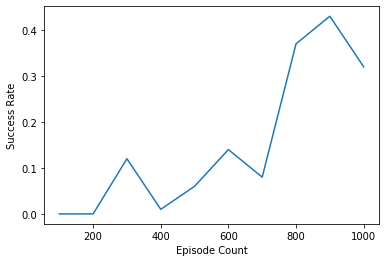

In [47]:
plt.plot(count,s_rate)
plt.xlabel('Episode Count')
plt.ylabel('Success Rate')
plt.show()

## Evaluation 

### To evaluate the quality of agent we are going to utilize  simulation evaluation.

### 1. Simulation Evaluation : This involves usage of 3 metrics to measure the quality {success rate, average turns, average reward}
    - Success rate   : Fraction of dialogues that ended successfully
    - Average turns  : Average length of the dialogue
    - Average reward : Average reward received during the conversation
    
### We are going to opt for a policy that has a high success rate, high average reward and low average returns.In our project we have chosen success rate as our primary evaluation metric